In [1]:
# Import required modules
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.special import rel_entr

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Use ggplot
matplotlib.style.use('ggplot')

features = ['target_material','target_thickness','pulse_width','energy','spot_size','intensity','power','cutoff_energy']


# Load original dataset that was used to generate samples
df_original = pd.read_csv('../1_sample_preparation/source/d_clean_remove_small_samples.csv')

df = pd.read_csv('../4_response_extraction/synthetic_data_rows.csv')

# Make sure all numeric features are floats / numeric
df[features[1:]] = df[features[1:]].astype(float)

# Drop column
df.drop(columns=['Unnamed: 0'],inplace=True)
df.reset_index(drop=True,inplace=True)

df

model      prompt_method prompt_short  \
0       claude-3-5-sonnet-20240620   chain_of_thought          cot   
1       claude-3-5-sonnet-20240620   chain_of_thought          cot   
2       claude-3-5-sonnet-20240620   chain_of_thought          cot   
3       claude-3-5-sonnet-20240620   chain_of_thought          cot   
4       claude-3-5-sonnet-20240620   chain_of_thought          cot   
...                            ...                ...          ...   
163295              phi3:mini-128k  reverse_prompting           rp   
163296              phi3:mini-128k  reverse_prompting           rp   
163297              phi3:mini-128k  reverse_prompting           rp   
163298              phi3:mini-128k  reverse_prompting           rp   
163299              phi3:mini-128k  reverse_prompting           rp   

        sample_size target_material  target_thickness   pulse_width  \
0         rs_size_5         plastic      3.010000e-01  3.500000e+01   
1         rs_size_5            gold      6.850000e-01  1.800000e+02   
2         rs_size_5       aluminium      9.520000e-01  4.200000e+01   
3         rs_size_5   polypropylene      1.230000e+00  3.200000e+02   
4         rs_size_5         plastic      4.880000e-01  3.000000e+01   
...             ...             ...               ...           ...   
163295  rs_size_100         plastic      1.450000e-01  3.631000e+00   
163296  rs_size_100        silicone      2.790000e+02  3.796000e+00   
163297  rs_size_100         plastic      5.450000e-01  1.580000e+00   
163298  rs_size_150         plastic      8.090000e-01  5.680000e+14   
163299  rs_size_150         plastic      4.930000e+20  2.846000e+13   

              energy     spot_size     intensity         power  cutoff_energy  
0       1.870000e+00  3.300000e+00  5.120000e+20  5.340000e+13   4.200000e+00  
1       3.250000e+00  3.300000e+00  7.210000e+20  1.810000e+13   6.800000e+00  
2       2.390000e+00  3.300000e+00  6.380000e+20  5.690000e+13   5.100000e+00  
3       1.560000e+01  4.100000e+00  1.450000e+21  4.880000e+13   1.830000e+01  
4       2.330000e+00  3.300000e+00  6.300000e+20  7.770000e+13   4.500000e+00  
...              ...           ...           ...           ...            ...  
163295  2.671000e+00  3.837000e+00  2.056000e+19  5.268000e+00   7.913000e+12  
163296  4.555000e+00  5.604000e+20  1.478000e+20  7.518000e+00   7.000000e+00  
163297  3.500000e+00  9.916100e+01  3.265000e+00  3.521000e+00   5.142000e+00  
163298  4.000000e+00  3.200000e+00  4.500000e+00  4.500000e+00   9.980000e-01  
163299  6.505000e+21  7.234000e+18  1.100000e+12  6.900000e+00   8.370000e+12  

[163300 rows x 12 columns]

Unique Materials: 458


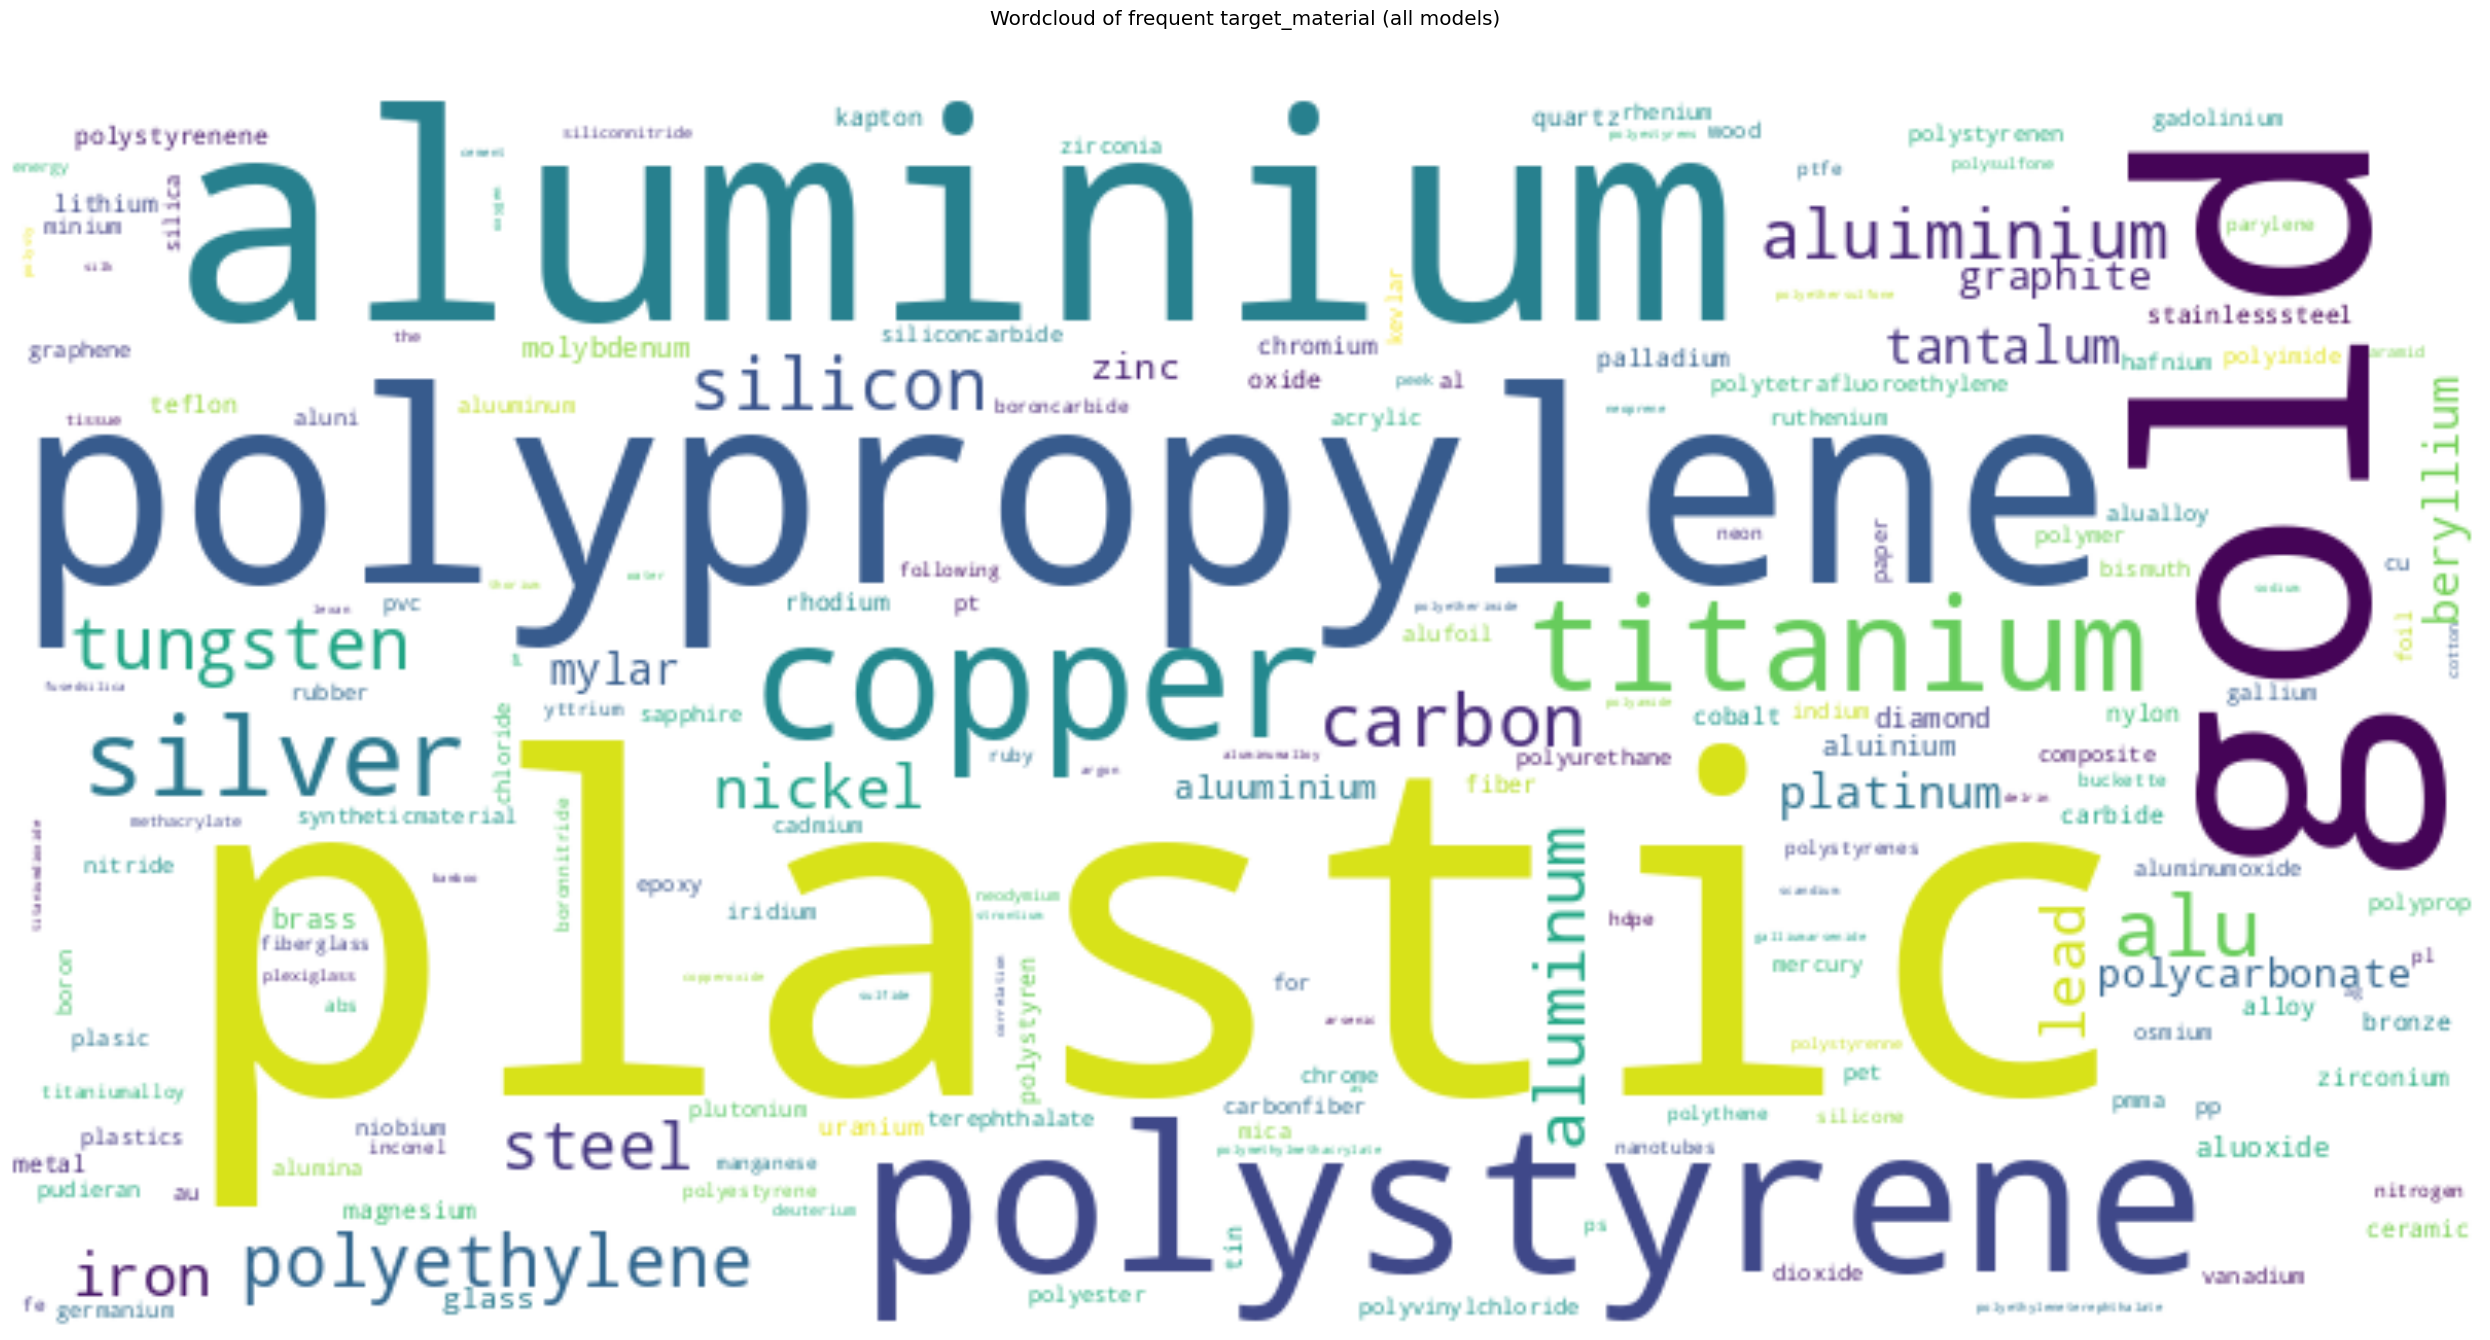

In [2]:
# Assuming 'df' is your DataFrame and it has already been processed to include the 'target_material' column correctly

# Count the occurrences of each 'target_material'
material_counts = df['target_material'].value_counts()

print('Unique Materials:',len(df['target_material'].unique()))

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color ='white')

# Generate a word cloud using the frequencies
wordcloud.generate_from_frequencies(material_counts.to_dict())

# Display the WordCloud image:
plt.figure(figsize=(25, 15))
plt.title('Wordcloud of frequent target_material (all models)',y=1.05)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels

plt.tight_layout()

plt.savefig('./images/word_cloud_target_material.jpg',dpi=800)
plt.show()

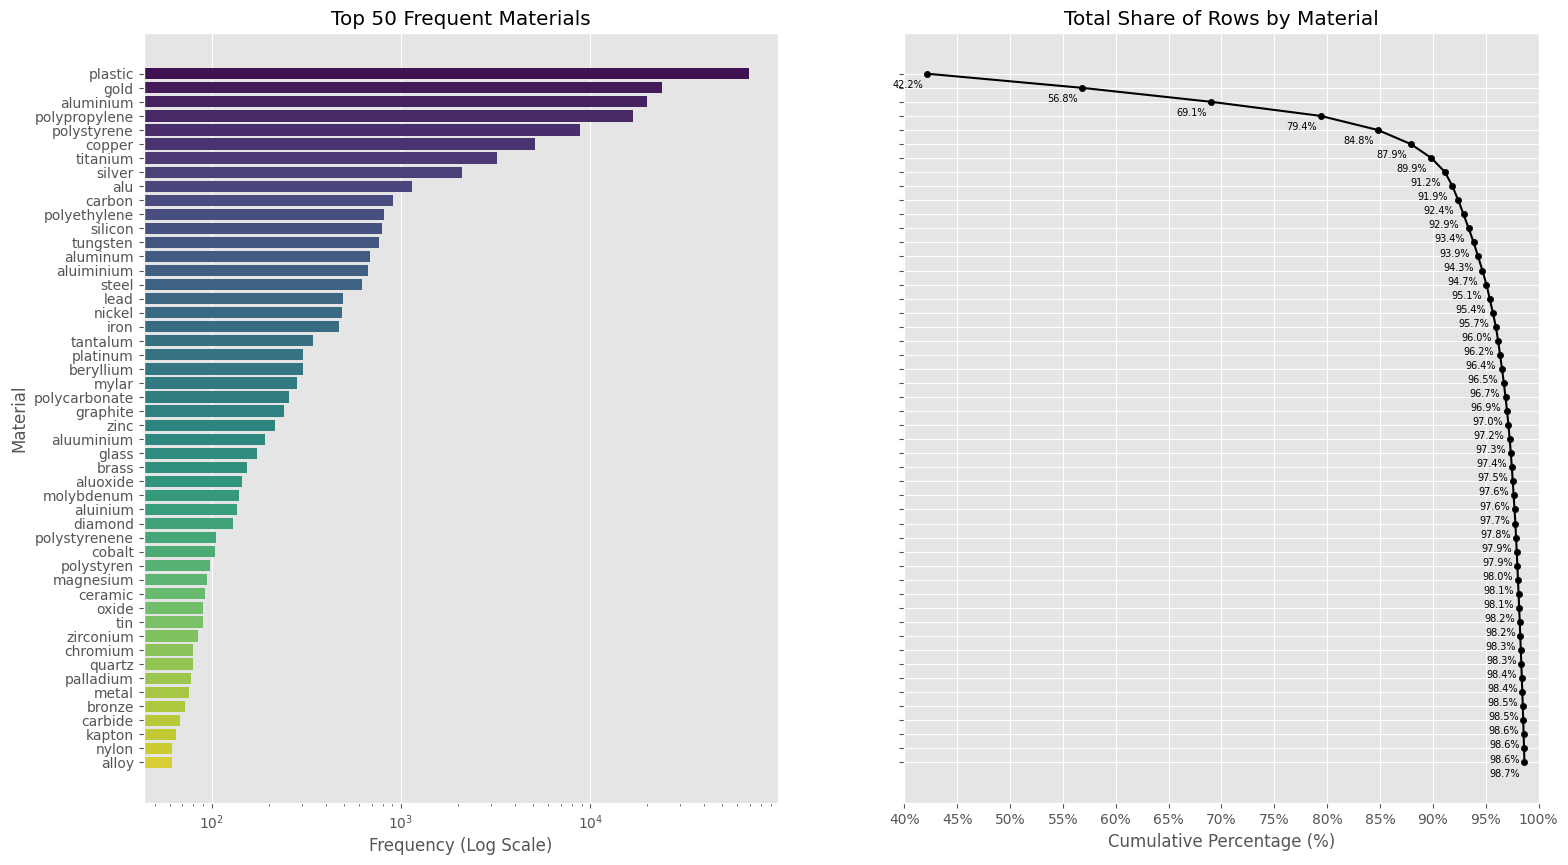

<Figure size 640x480 with 0 Axes>

In [3]:
# Assuming 'material_counts' holds the value counts of 'target_material' from your DataFrame
top_25_materials = material_counts.head(50)  # Get the top 50 materials for better illustration

# Create a DataFrame from the top 25 materials for easier plotting
top_25_df = pd.DataFrame(top_25_materials).reset_index()
top_25_df.columns = ['target_material', 'count']

# Calculate cumulative percentage
total_rows = df.shape[0]  # Total number of rows in the original DataFrame
top_25_df['cumulative_percent'] = top_25_df['count'].cumsum() / total_rows * 100

# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True)  # Share y-axis across subplots

# Left subplot for frequency
sns.barplot(x='count', y='target_material', data=top_25_df, ax=axes[0], hue='target_material',palette='viridis')
axes[0].set_xscale('log')
axes[0].set_xlabel('Frequency (Log Scale)')
axes[0].set_ylabel('Material')
axes[0].set_title('Top 50 Frequent Materials')

# Right subplot for cumulative percentage
sns.lineplot(x='cumulative_percent', y='target_material', data=top_25_df, ax=axes[1],color='black')
axes[1].set_xlabel('Cumulative Percentage (%)')
axes[1].set_title('Total Share of Rows by Material')

# Set x-axis to have a tick every 5 percent
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))

# Optionally, you can format the ticks to show them as percentages
axes[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

# If you want to limit the x-axis to show up to 100% only
axes[1].set_xlim(40, 100)

# Annotate each point on the line plot
for index, row in top_25_df.iterrows():
    axes[1].annotate(f"{row['cumulative_percent']:.1f}%", 
                     (row['cumulative_percent'], row['target_material']), 
                     textcoords="offset points", 
                     xytext=(-14,-10), 
                     ha='center', 
                     color='black', 
                     size=7,
    )
# Plotting the points as black dots
axes[1].scatter(top_25_df['cumulative_percent'], top_25_df['target_material'], color='black', s=20)  # s is the size of the dot

plt.show()

# Improve layout
plt.tight_layout()

# Save the figure
plt.savefig('./images/top_50_materials_comparison.jpg', dpi=300)
# Display the plot
plt.show()


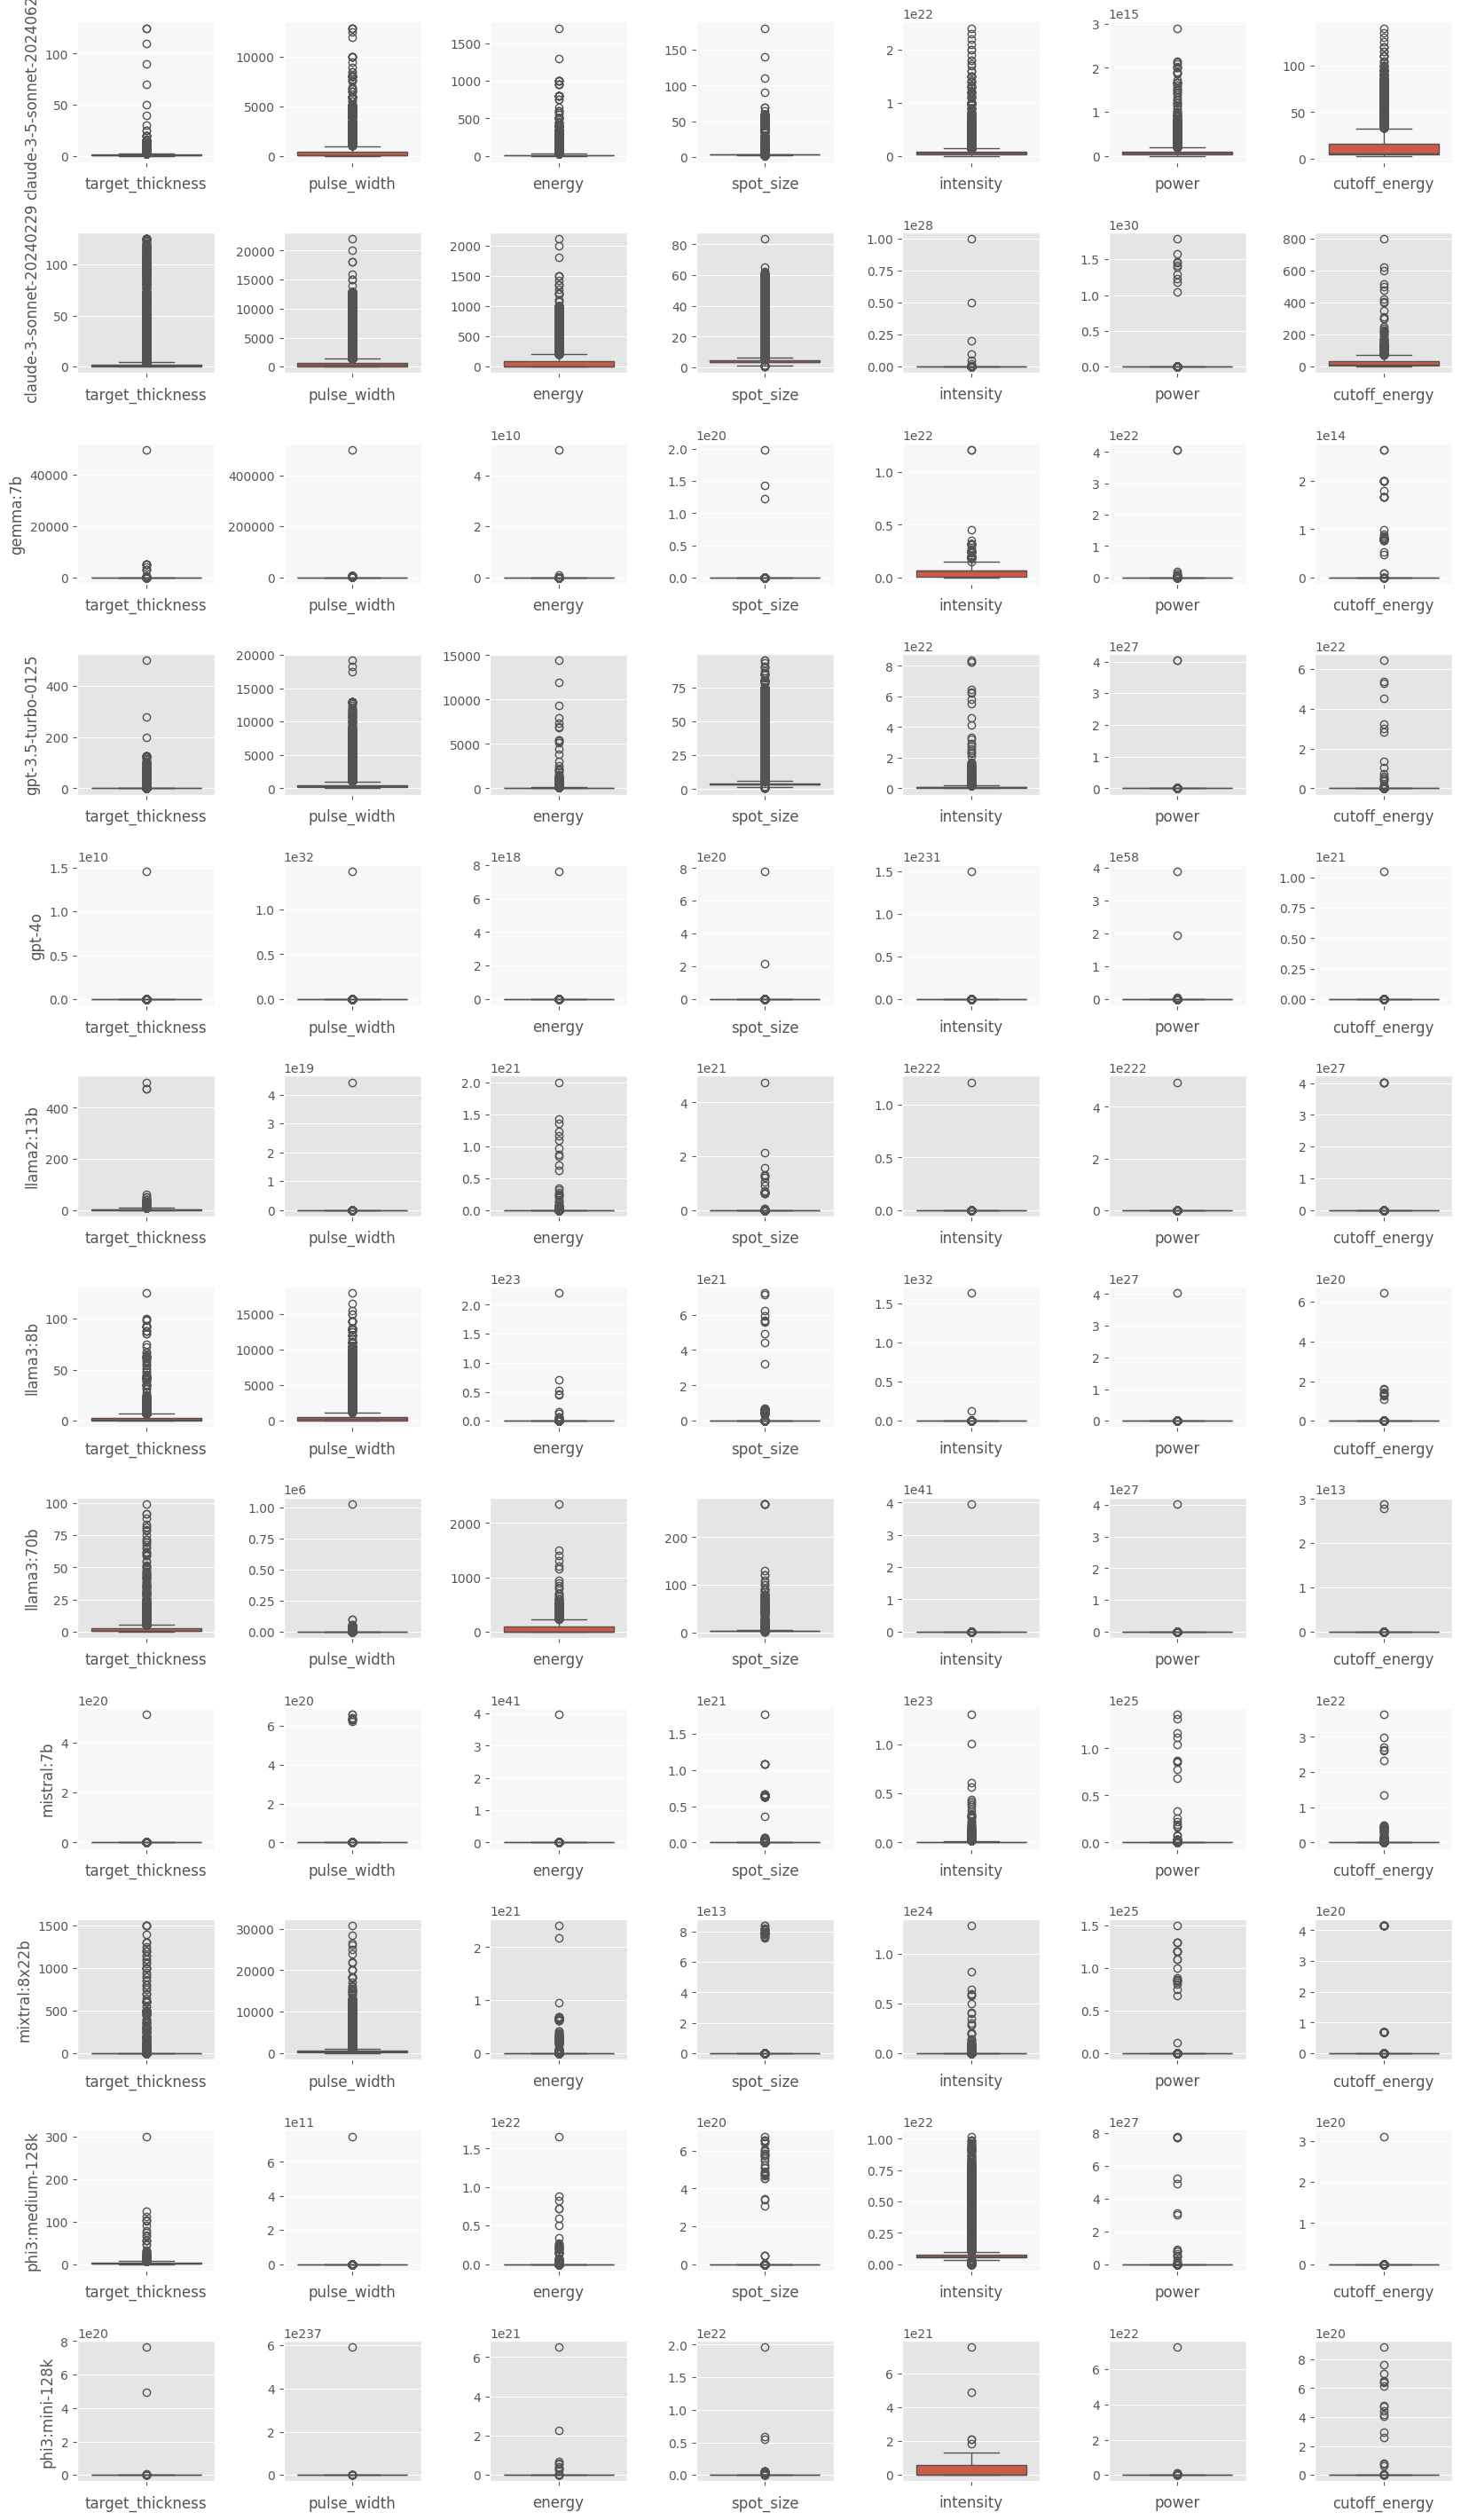

In [4]:
# Assuming 'df' is your DataFrame
numeric_features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

num_models = len(df['model'].unique())
# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(num_models, len(numeric_features), figsize=(20, 3 * num_models))

for i, model_name in enumerate(df['model'].unique()):
    # Filter the DataFrame for the specific model
    model_df = df[df['model'] == model_name]

    for j, feature in enumerate(numeric_features):
        # Create a boxplot for the numeric features of this specific model
        ax = sns.boxplot(data=model_df, y=feature, ax=axes[i, j], orient='v')
        # Set the xlabel on each subplot
        axes[i, j].set_xlabel(feature)
        
        # Only set the ylabel for the first column
        if j == 0:
            axes[i, j].set_ylabel(model_name)
        else:
            axes[i, j].set_ylabel('')  # Remove y-label for other columns

        # Add shaded background for alternating rows
        if i % 2 == 0:  # Shade only even indexed rows (Python indexing starts at 0)
            ax.patch.set_facecolor((0.97, 0.97, 0.97))  # Light grey color, adjust the RGB values as needed

# Increase spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.savefig('./images/boxplot_outliers_models.jpg',dpi=300)
# Display the plot
plt.show()


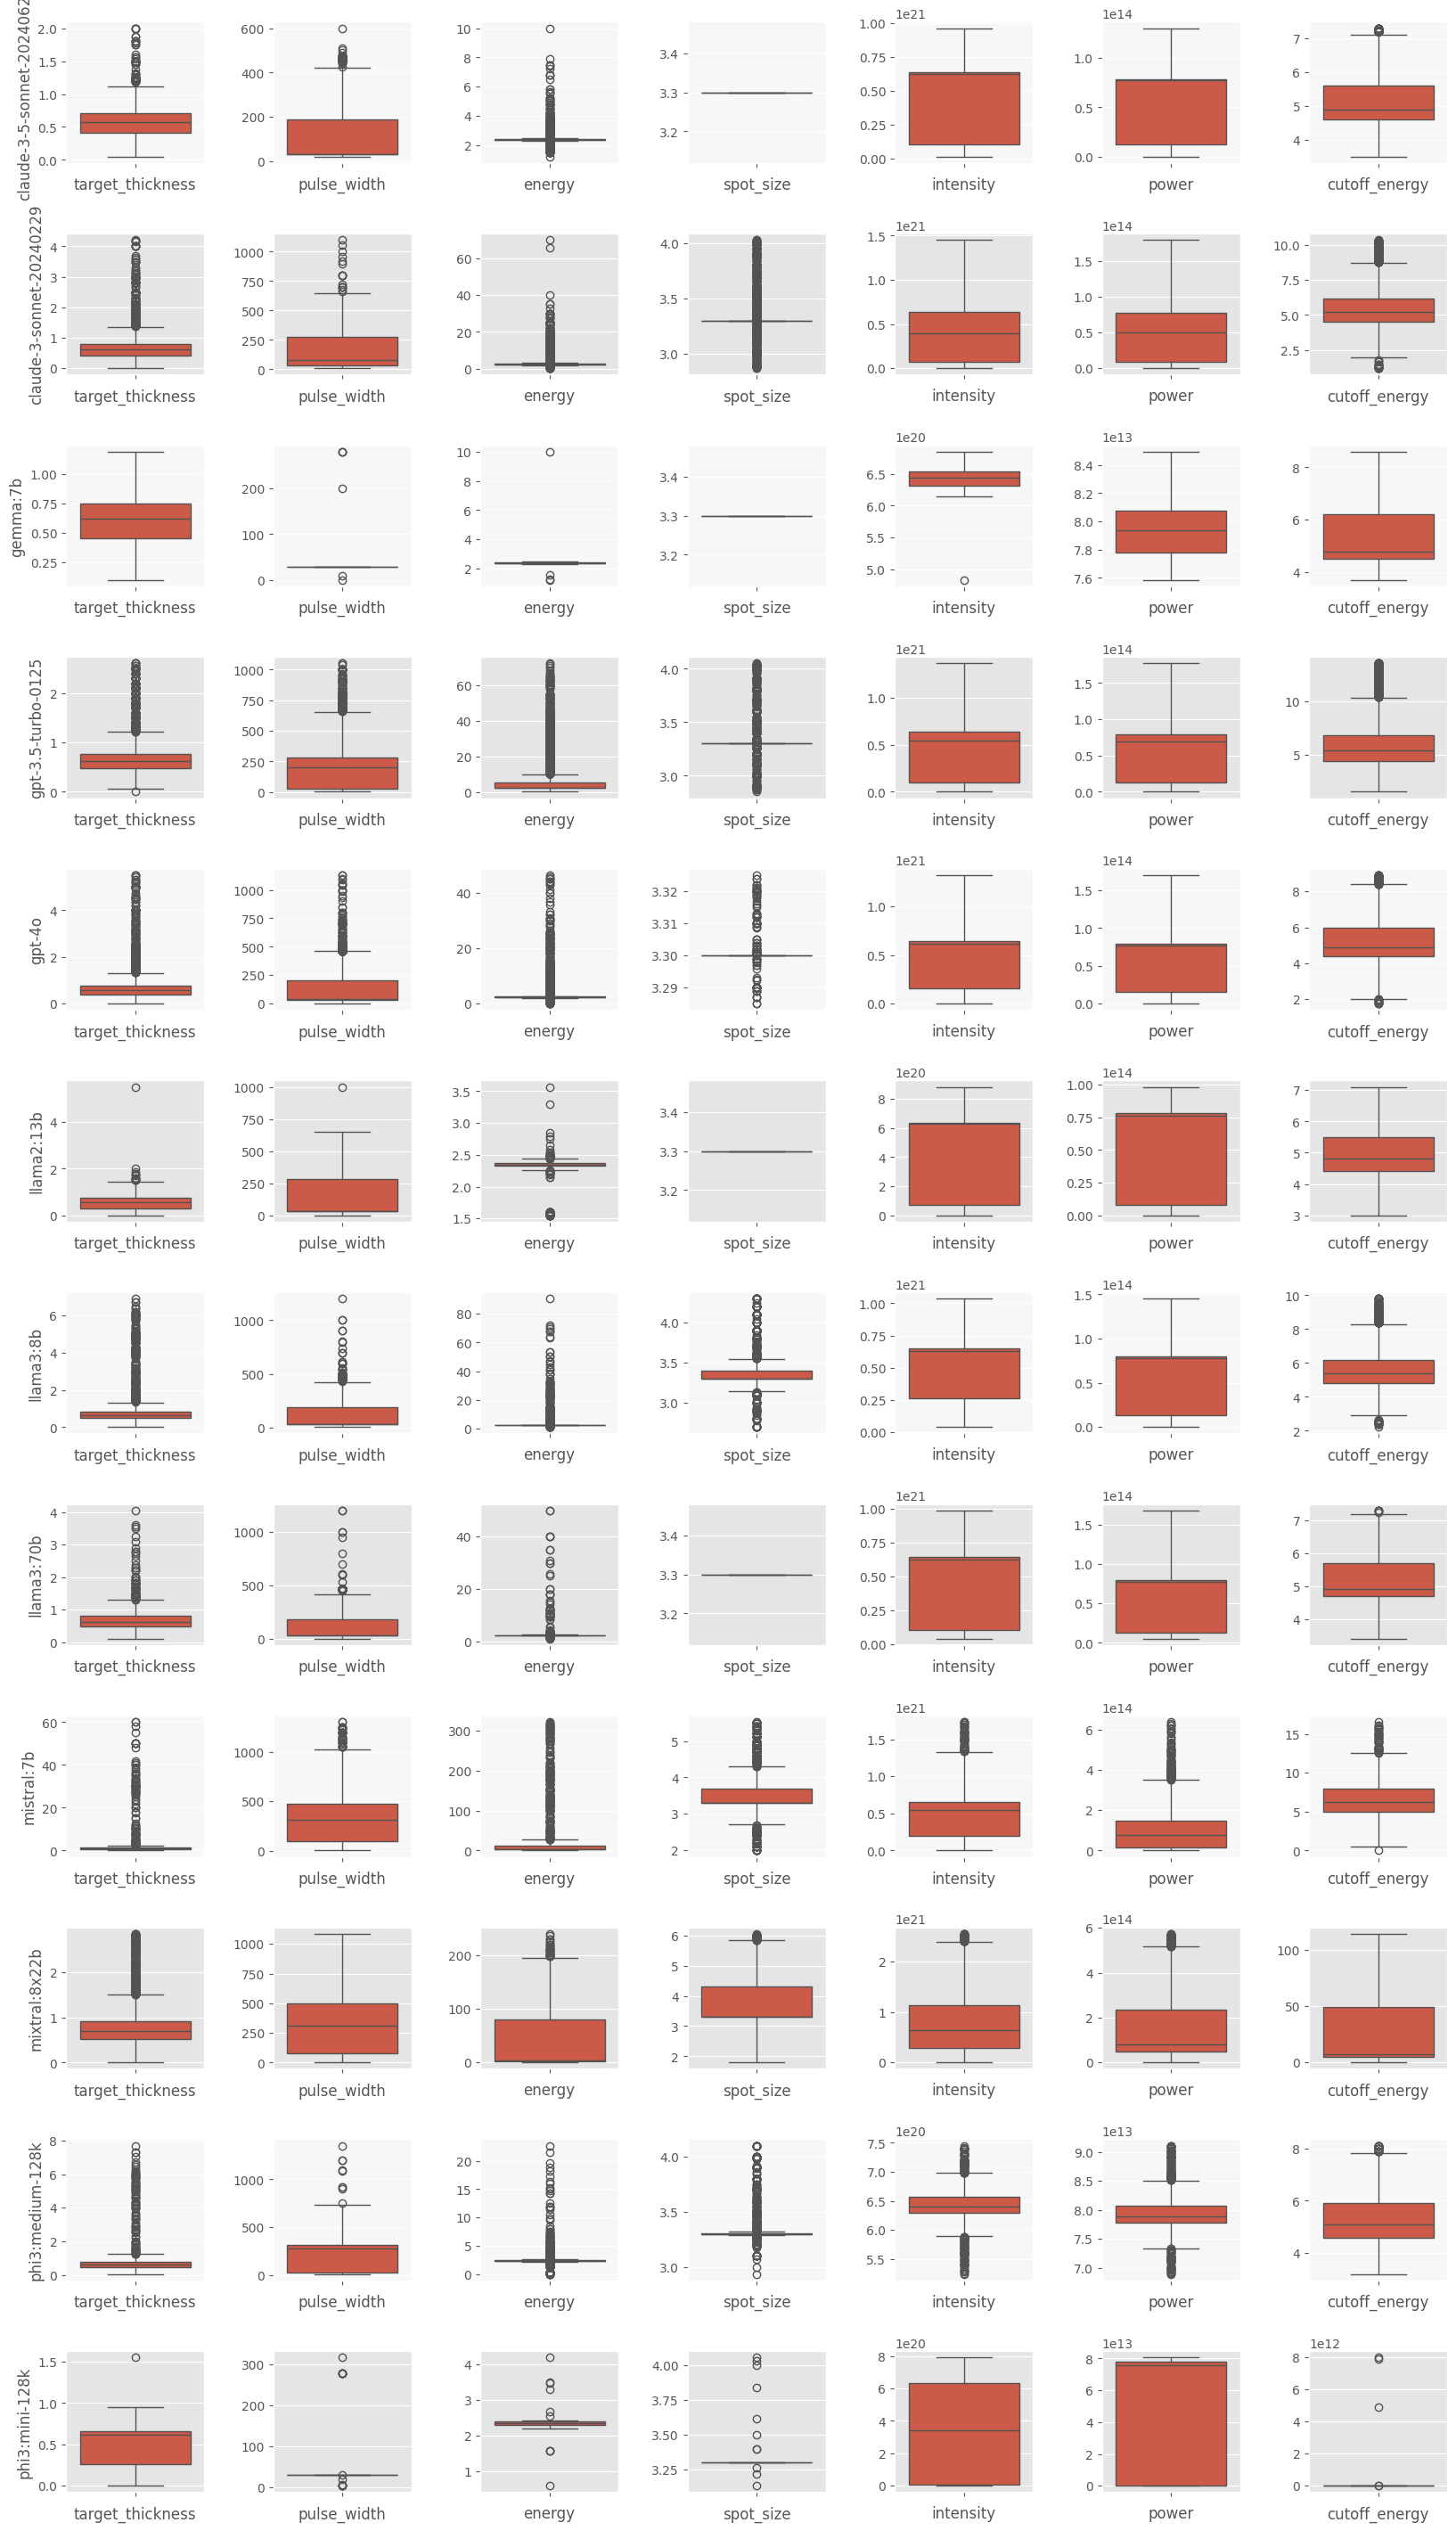

In [5]:
# Assuming 'df' is your DataFrame
numeric_features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

num_models = len(df['model'].unique())
# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(num_models, len(numeric_features), figsize=(20, 3 * num_models))

# Function to remove outliers for a specific feature
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

for i, model_name in enumerate(df['model'].unique()):
    # Filter the DataFrame for the specific model
    model_df = df[df['model'] == model_name]

    # Remove outliers for all numeric features
    for feature in numeric_features:
        model_df = remove_outliers(model_df, feature)

    for j, feature in enumerate(numeric_features):
        # Create a boxplot for the numeric features of this specific model
        ax = sns.boxplot(data=model_df, y=feature, ax=axes[i, j], orient='v')
        # Set the xlabel on each subplot
        axes[i, j].set_xlabel(feature)
        
        # Only set the ylabel for the first column
        if j == 0:
            axes[i, j].set_ylabel(model_name)
        else:
            axes[i, j].set_ylabel('')  # Remove y-label for other columns
        
        # Add shaded background for alternating rows
        if i % 2 == 0:  # Shade only even indexed rows (Python indexing starts at 0)
            ax.patch.set_facecolor((0.97, 0.97, 0.97))  # Light grey color, adjust the RGB values as needed

# Increase spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Save and display the plot
plt.savefig('./images/boxplot_outliers_remove_iqr1_5_models.jpg', dpi=300)
plt.show()


In [6]:
# Assuming 'df' is your DataFrame
numeric_features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Create a copy of the original DataFrame
df_remove_outliers = df.copy()

# Function to remove outliers for a specific feature
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.10)
    Q3 = df[feature].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Remove outliers for all numeric features
for feature in numeric_features:
    df_remove_outliers = remove_outliers(df_remove_outliers, feature)

print(f"Original DataFrame length: {len(df)}")
print(f"DataFrame length after removing outliers: {len(df_remove_outliers)}")

df_remove_outliers

Original DataFrame length: 163300
DataFrame length after removing outliers: 131478


model                        prompt_method  \
0       claude-3-5-sonnet-20240620                     chain_of_thought   
1       claude-3-5-sonnet-20240620                     chain_of_thought   
2       claude-3-5-sonnet-20240620                     chain_of_thought   
3       claude-3-5-sonnet-20240620                     chain_of_thought   
4       claude-3-5-sonnet-20240620                     chain_of_thought   
...                            ...                                  ...   
163277              phi3:mini-128k  recursive_criticism_and_improvement   
163279              phi3:mini-128k  recursive_criticism_and_improvement   
163280              phi3:mini-128k  recursive_criticism_and_improvement   
163283              phi3:mini-128k  recursive_criticism_and_improvement   
163286              phi3:mini-128k                    reverse_prompting   

       prompt_short  sample_size target_material  target_thickness  \
0               cot    rs_size_5         plastic             0.301   
1               cot    rs_size_5            gold             0.685   
2               cot    rs_size_5       aluminium             0.952   
3               cot    rs_size_5   polypropylene             1.230   
4               cot    rs_size_5         plastic             0.488   
...             ...          ...             ...               ...   
163277         rcai   rs_size_50   polypropylene             0.800   
163279         rcai   rs_size_50         plastic             0.620   
163280         rcai   rs_size_50            gold             0.850   
163283         rcai  rs_size_150             mrk             0.525   
163286           rp   rs_size_25         plastic             0.263   

        pulse_width   energy  spot_size     intensity         power  \
0            35.000    1.870      3.300  5.120000e+20  5.340000e+13   
1           180.000    3.250      3.300  7.210000e+20  1.810000e+13   
2            42.000    2.390      3.300  6.380000e+20  5.690000e+13   
3           320.000   15.600      4.100  1.450000e+21  4.880000e+13   
4            30.000    2.330      3.300  6.300000e+20  7.770000e+13   
...             ...      ...        ...           ...           ...   
163277      500.000  146.610      4.406  1.334000e+21  2.932000e+14   
163279      279.000    2.375      3.300  6.450000e+19  8.000000e+13   
163280      279.000    2.360      3.300  6.455000e+19  7.900000e+13   
163283        4.934    3.539      4.300  5.671000e-19  6.200000e+00   
163286       30.000    2.327      3.300  6.289000e+20  7.756000e+13   

        cutoff_energy  
0                 4.2  
1                 6.8  
2                 5.1  
3                18.3  
4                 4.5  
...               ...  
163277           54.5  
163279            4.0  
163280            5.0  
163283            4.4  
163286            4.8  

[131478 rows x 12 columns]

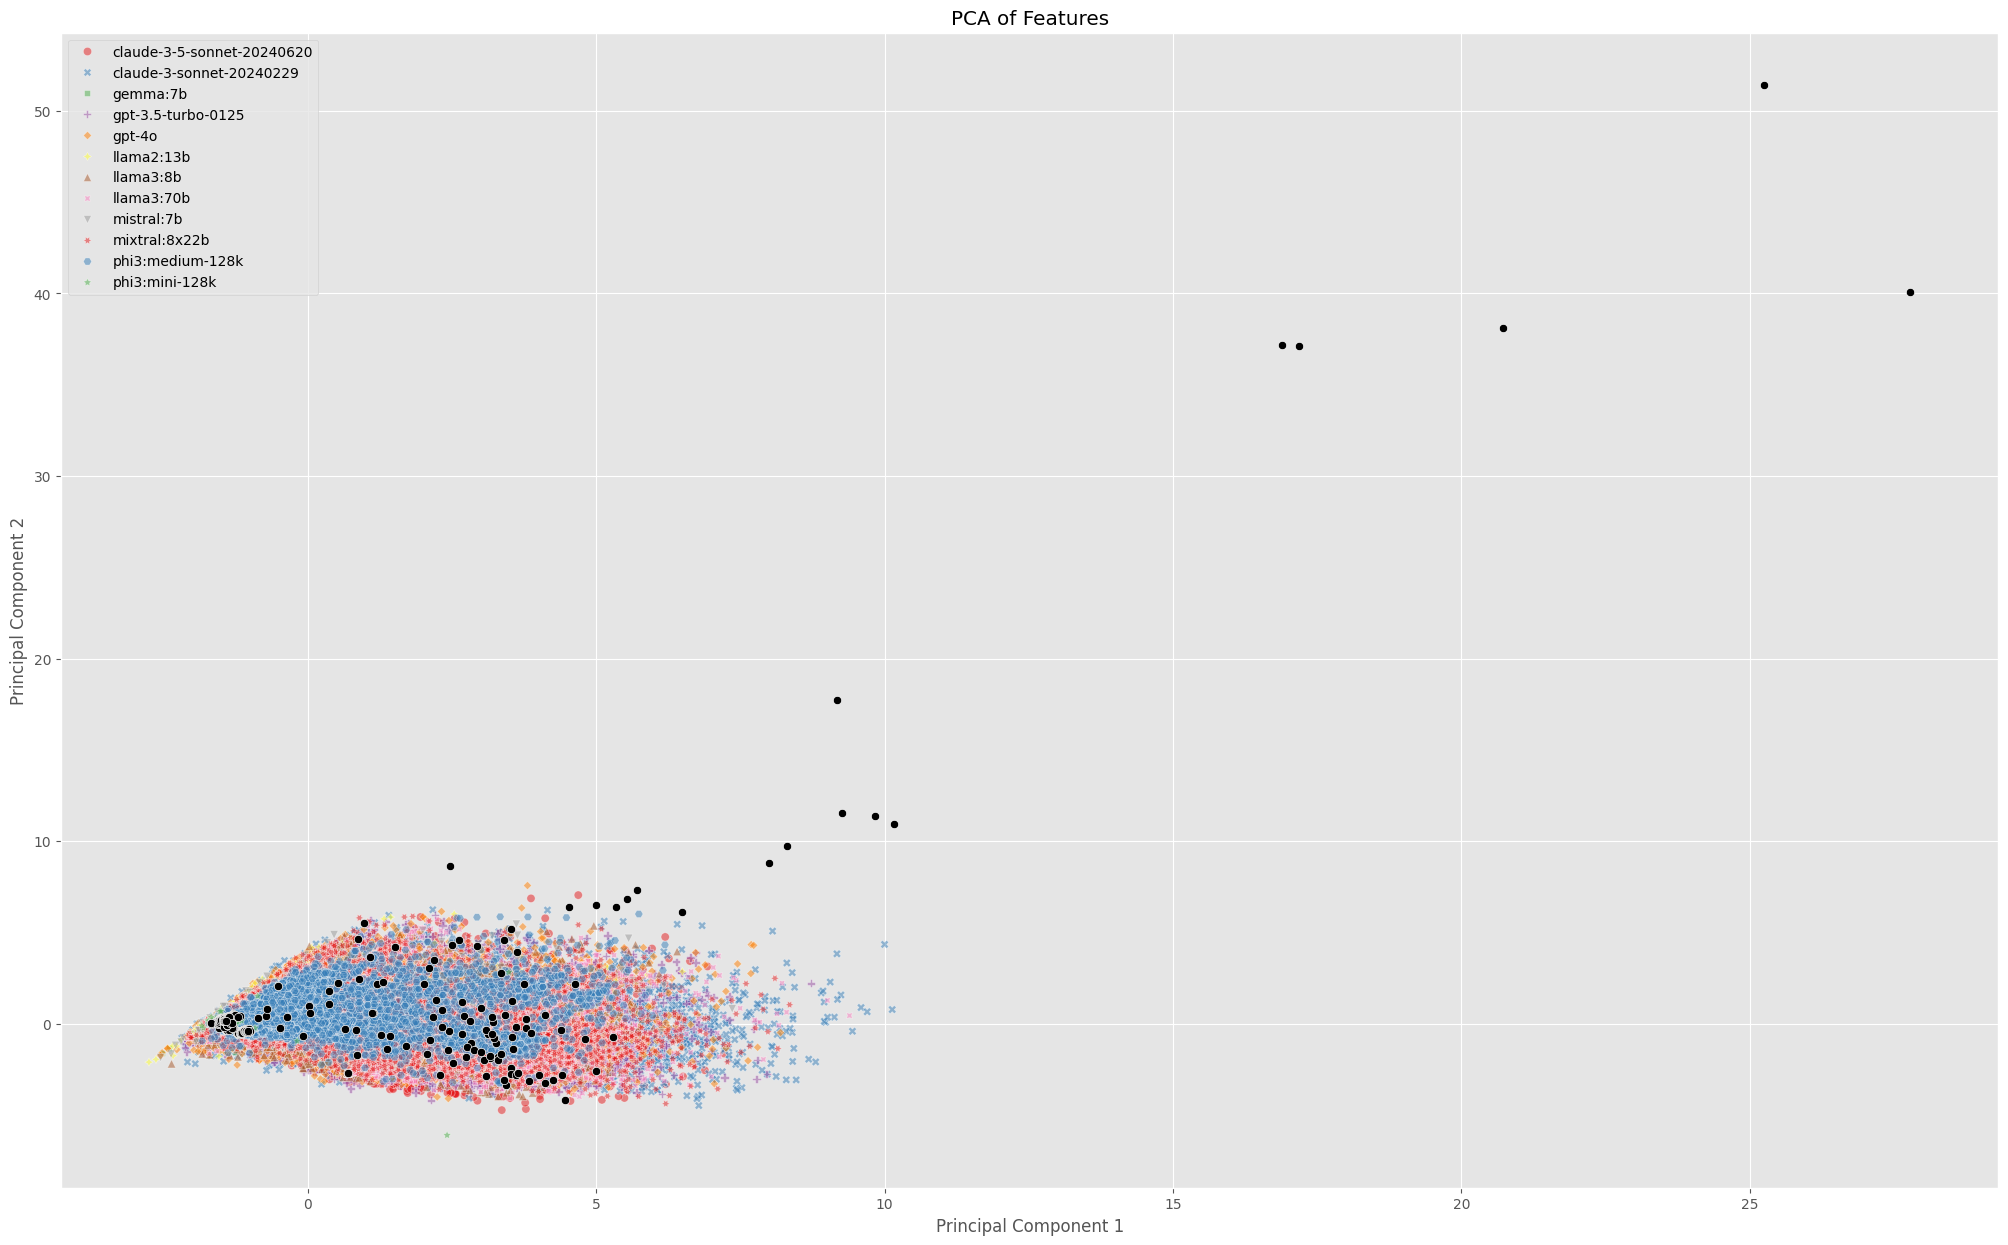

In [7]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for PCA
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Now proceed with PCA on the combined DataFrame
X = combined_df[features].copy()  # Create a copy to avoid SettingWithCopyWarning

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Proceed with PCA
pca = PCA(n_components=2)  # Example: reducing to 2 principal components
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Adding the source and model information back to the PCA DataFrame
pca_df = pd.concat([pca_df, combined_df.reset_index(drop=True)[['source', 'model']]], axis=1)

# Handle NaNs in the 'model' column for original data
pca_df['model'].fillna('original', inplace=True)

# Separate the synthetic and original data points
synthetic_points = pca_df[pca_df['source'] == 'synthetic']
original_points = pca_df[pca_df['source'] == 'original']

# Plotting the PCA result
plt.figure(figsize=(25, 15))

# Plot synthetic points first
sns.scatterplot(data=synthetic_points, x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=True)

# Plot original points on top in black
sns.scatterplot(data=original_points, x='Principal Component 1', y='Principal Component 2', color='black')

plt.title('PCA of Features')
plt.show()


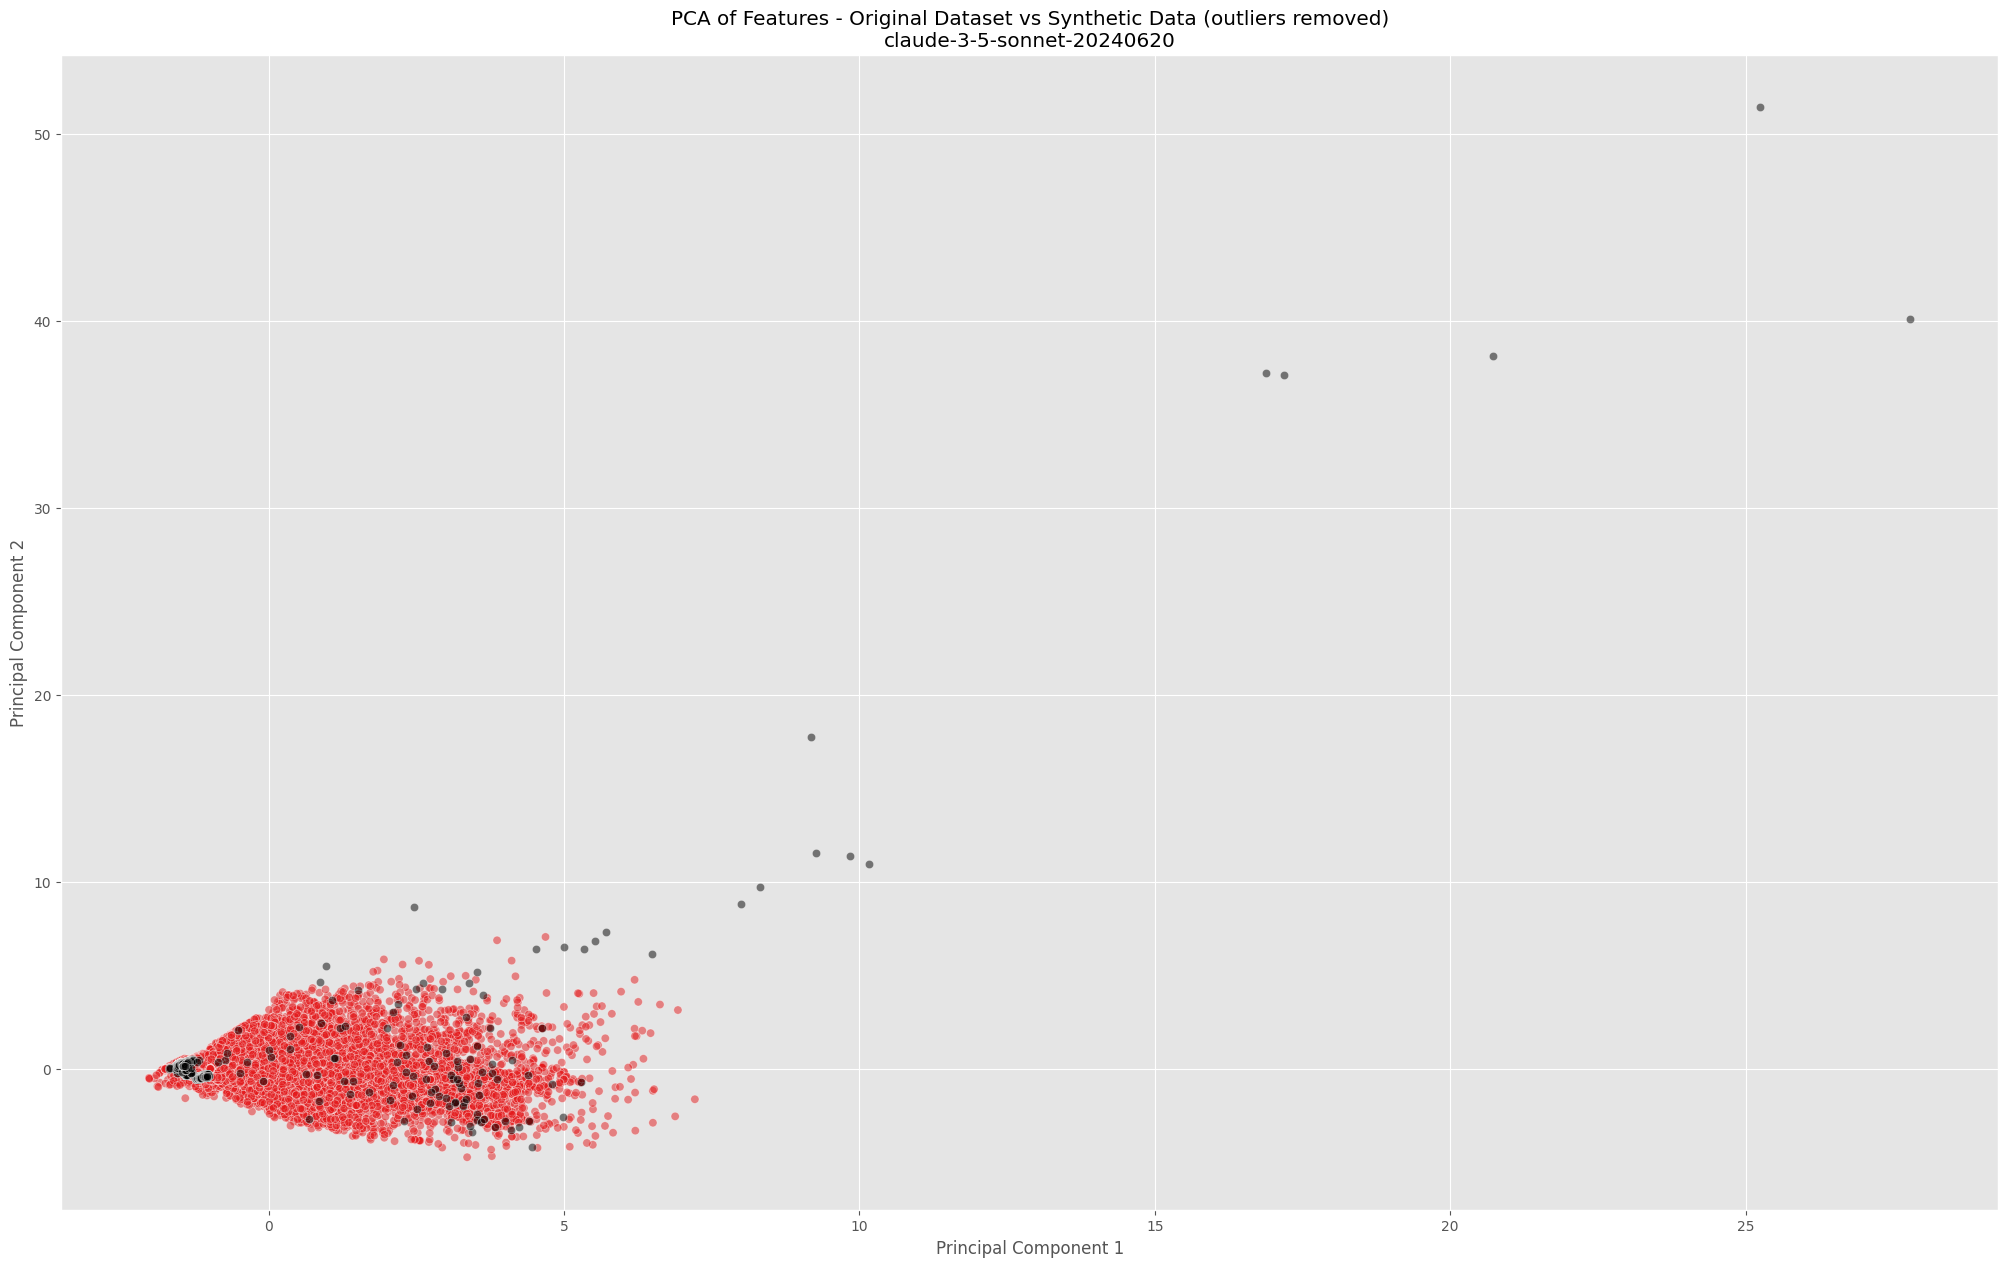

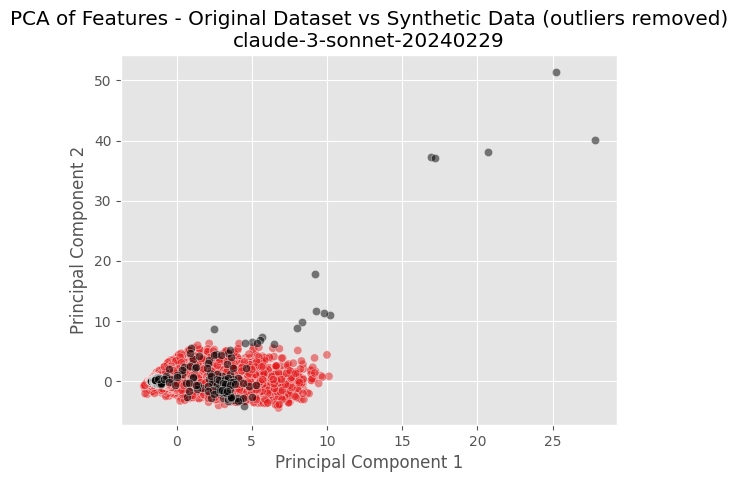

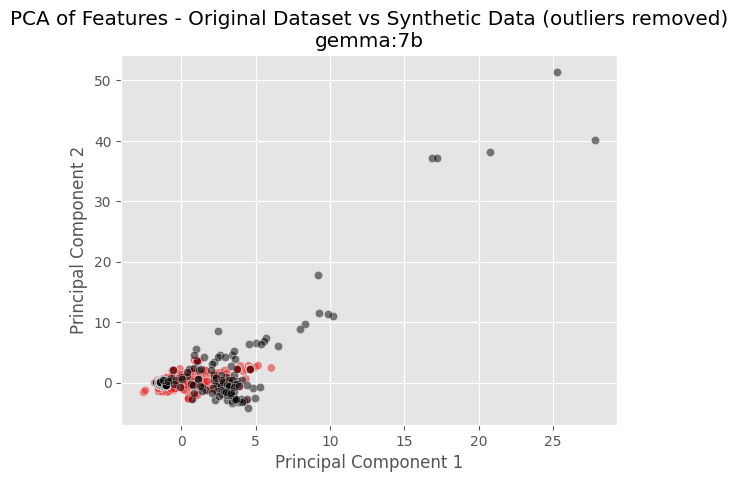

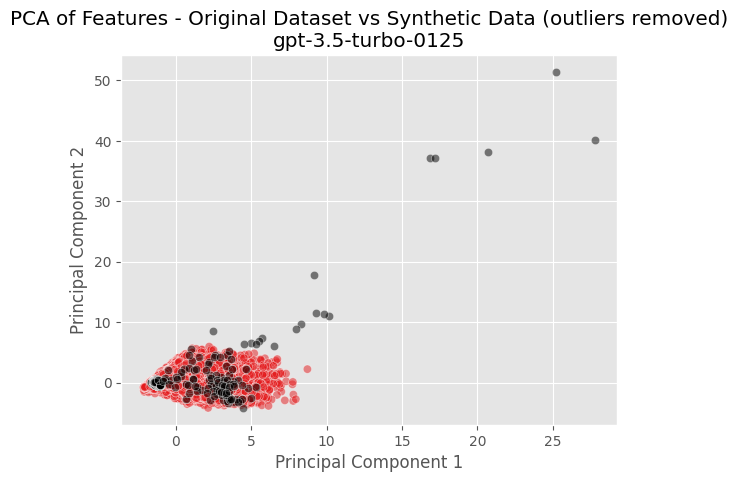

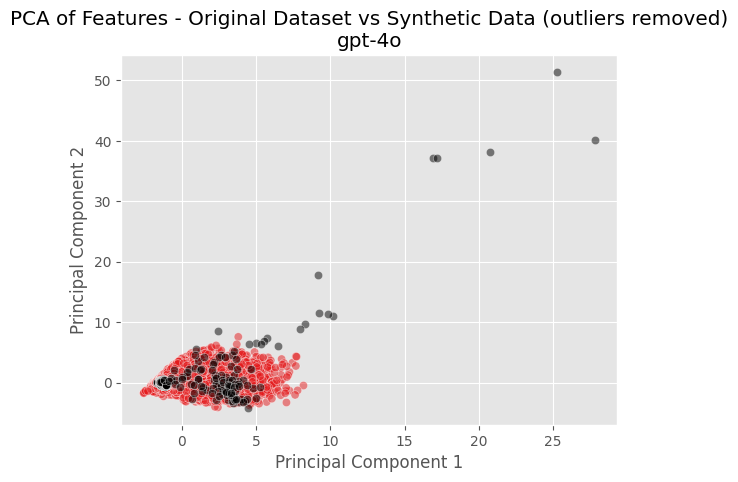

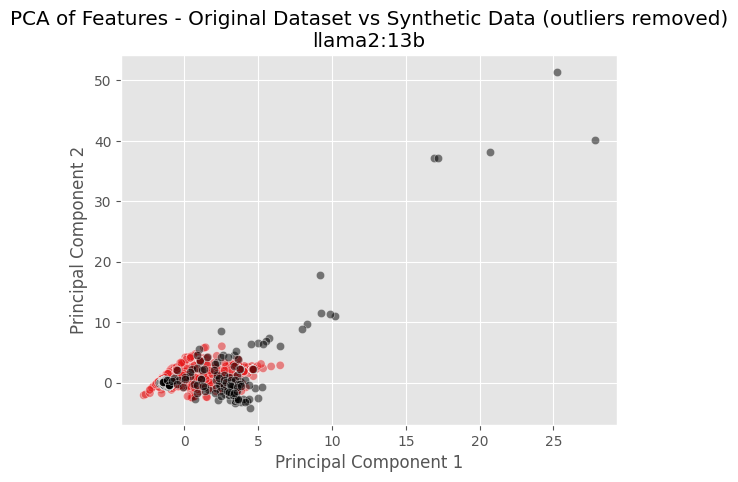

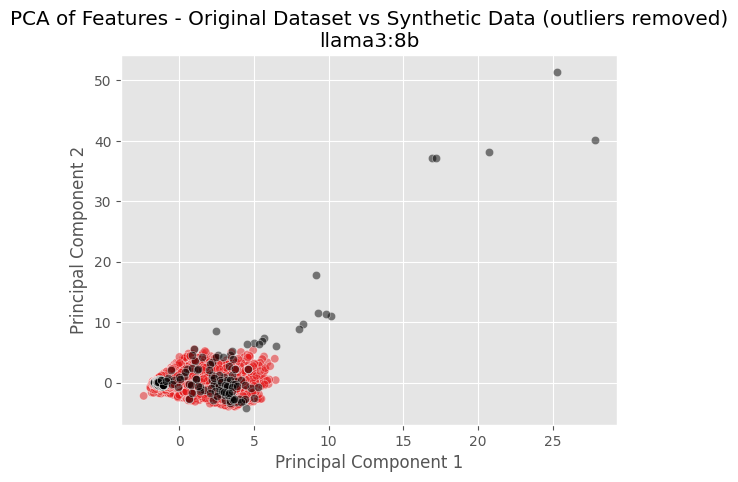

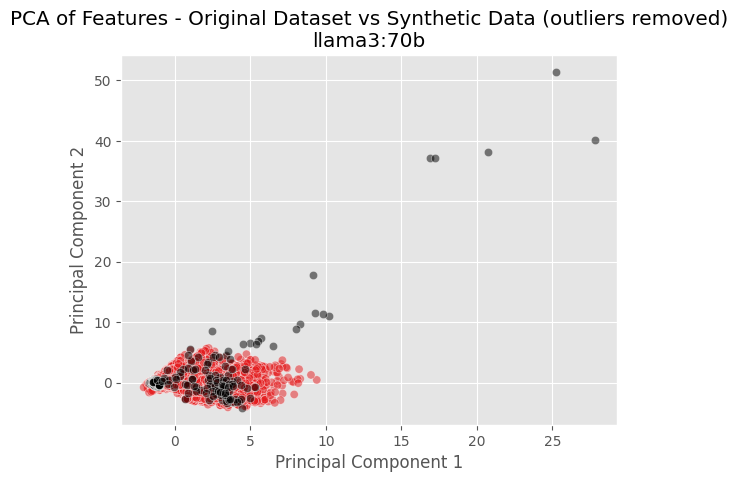

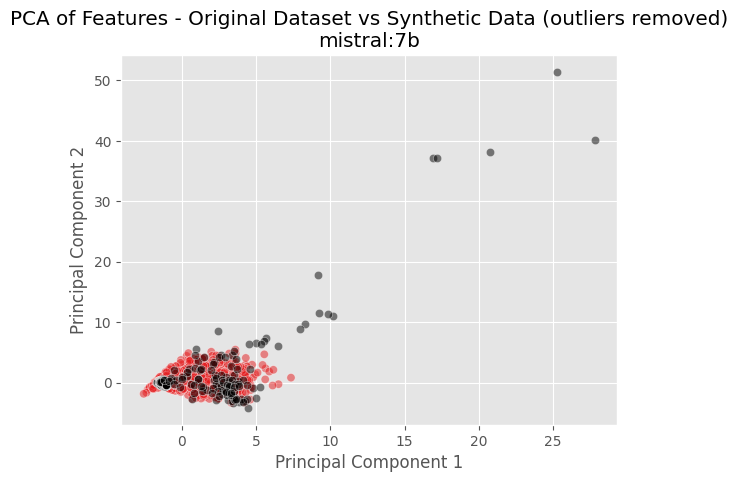

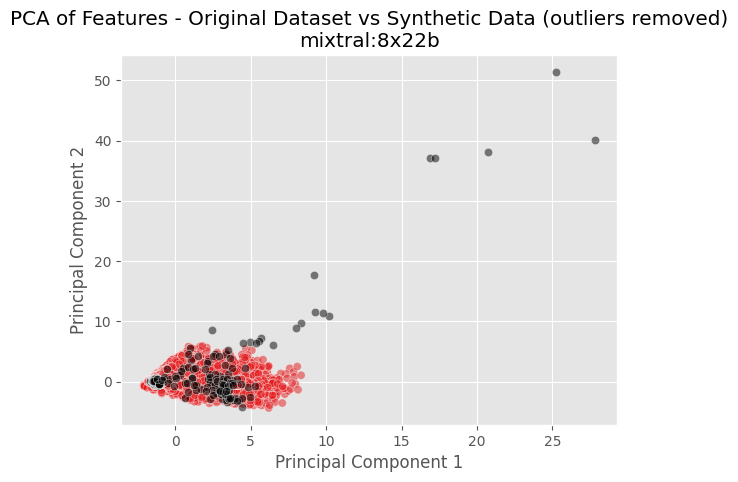

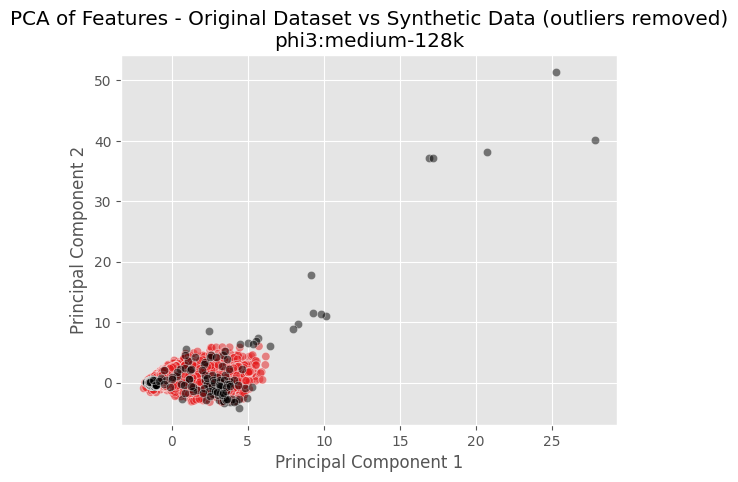

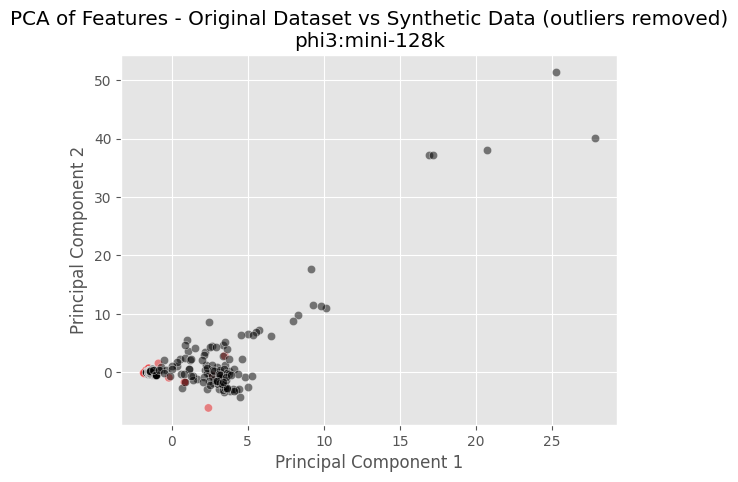

In [8]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for PCA
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Now proceed with PCA on the combined DataFrame
X = combined_df[features].copy()  # Create a copy to avoid SettingWithCopyWarning

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Proceed with PCA
pca = PCA(n_components=2)  # Example: reducing to 2 principal components
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Adding the source and model information back to the PCA DataFrame
pca_df = pd.concat([pca_df, combined_df.reset_index(drop=True)[['source', 'model']]], axis=1)

# Handle NaNs in the 'model' column for original data
pca_df['model'].fillna('original', inplace=True)

# Separate the synthetic and original data points
synthetic_points = pca_df[pca_df['source'] == 'synthetic']
original_points = pca_df[pca_df['source'] == 'original']

# Plotting the PCA result
plt.figure(figsize=(25, 15))

for i, model_name in enumerate(df['model'].unique()):
    # Plot synthetic points first
    sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)

    # Plot original points on top in black
    sns.scatterplot(data=original_points, x='Principal Component 1', y='Principal Component 2', color='black', alpha=0.5,)

    plt.title(f'PCA of Features - Original Dataset vs Synthetic Data (outliers removed)\n{model_name}')

    plt.savefig(f'./images/pca_original_vs_synth_{model_name}.jpg',dpi=300)
    plt.show()


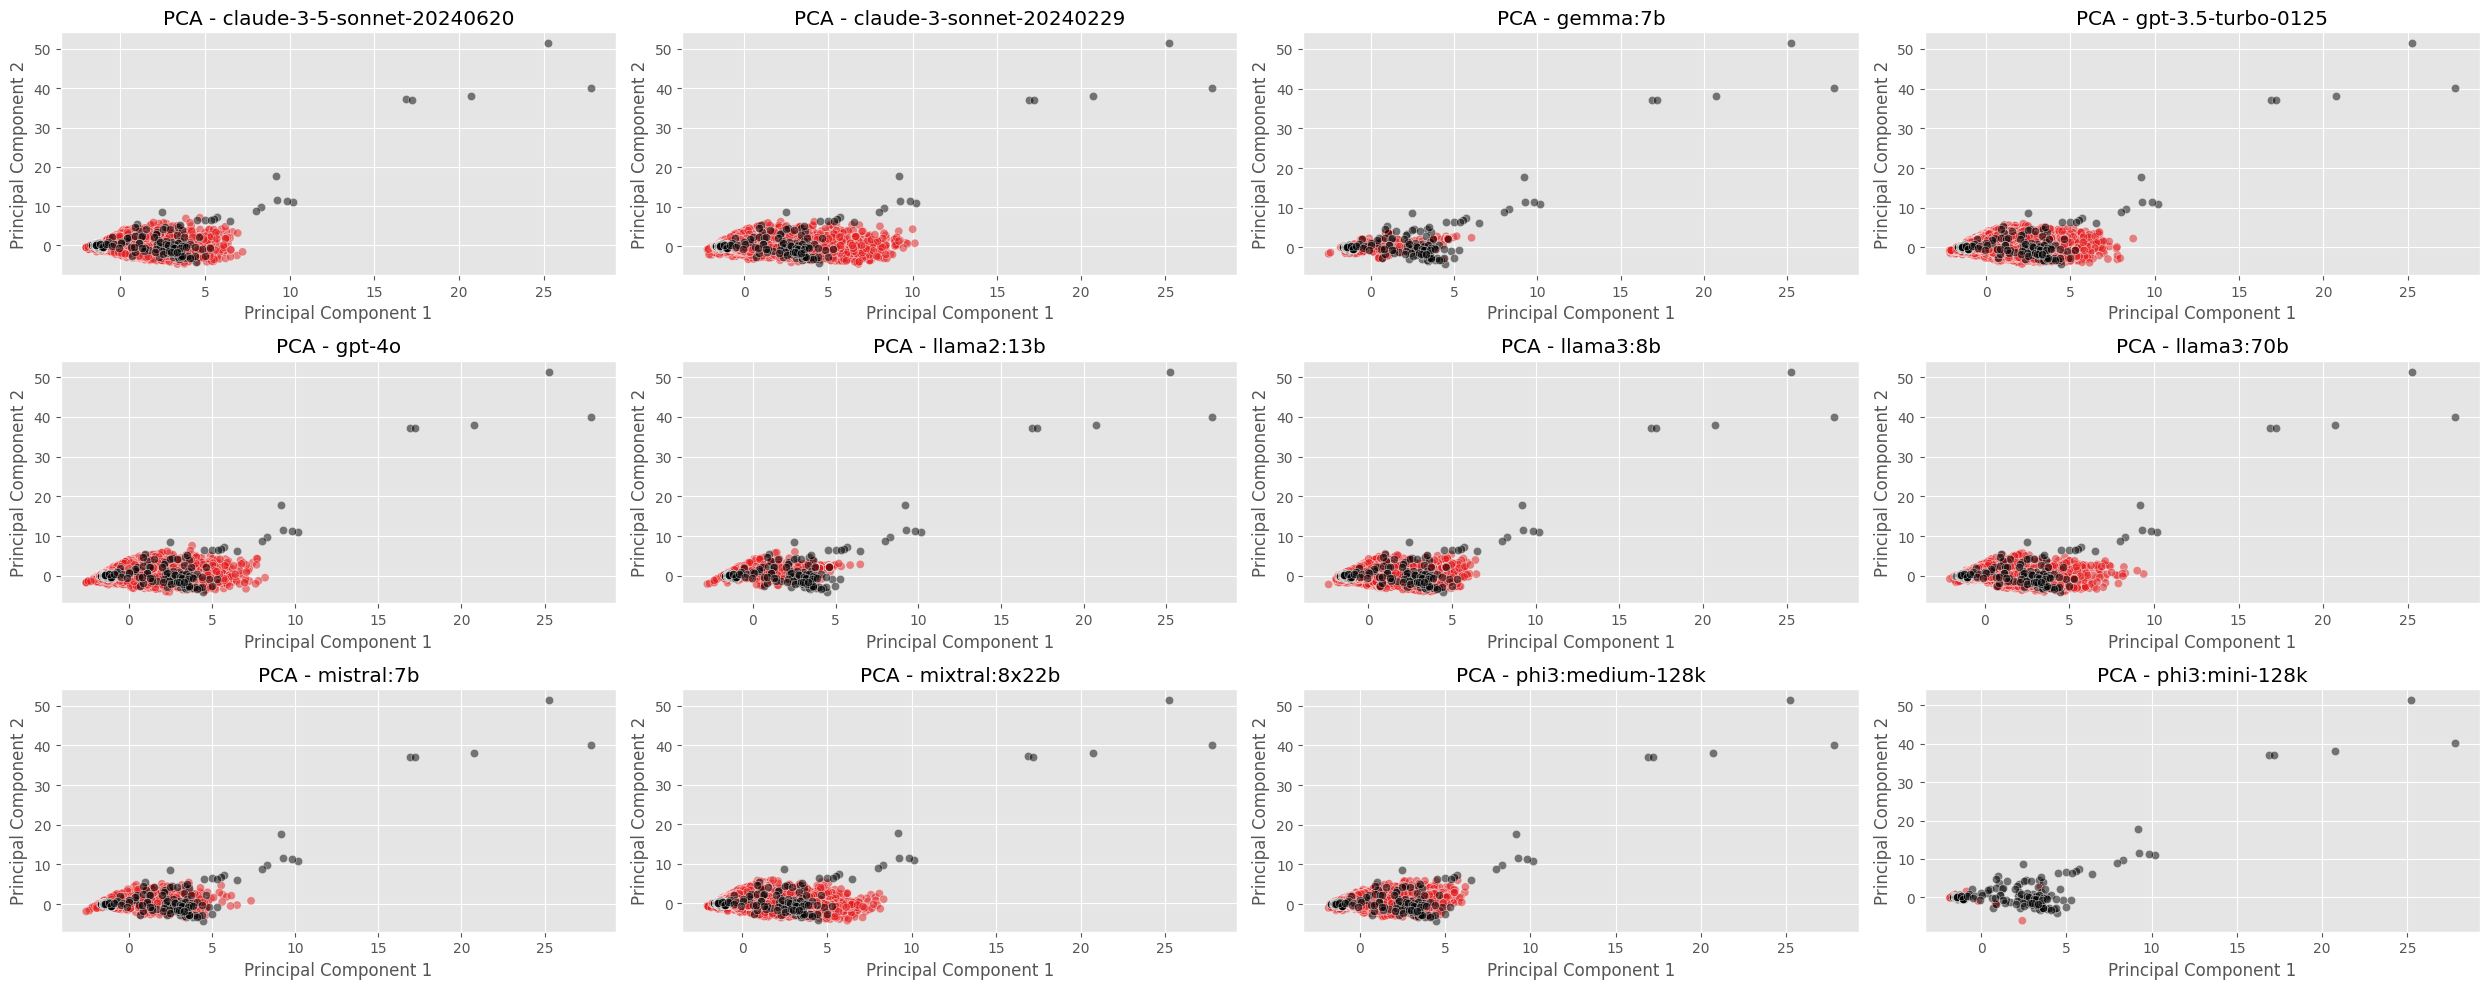

In [11]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for PCA
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Now proceed with PCA on the combined DataFrame
X = combined_df[features].copy()  # Create a copy to avoid SettingWithCopyWarning

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Proceed with PCA
pca = PCA(n_components=2)  # Example: reducing to 2 principal components
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Adding the source and model information back to the PCA DataFrame
pca_df = pd.concat([pca_df, combined_df.reset_index(drop=True)[['source', 'model']]], axis=1)

# Handle NaNs in the 'model' column for original data
pca_df['model'].fillna('original', inplace=True)

# Separate the synthetic and original data points
synthetic_points = pca_df[pca_df['source'] == 'synthetic']
original_points = pca_df[pca_df['source'] == 'original']

# Create subplots
fig, axes = plt.subplots(3, 4, figsize=(25, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

for i, model_name in enumerate(df_remove_outliers['model'].unique()):
    ax = axes[i]
    # Plot synthetic points first
    sns.scatterplot(data=synthetic_points[synthetic_points['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False, ax=ax)

    # Plot original points on top in black
    sns.scatterplot(data=original_points, x='Principal Component 1', y='Principal Component 2', color='black', alpha=0.5, ax=ax)

    ax.set_title(f'PCA - {model_name}')

# Adjust layout
plt.tight_layout()

plt.savefig('./images/pca_all_models_orig_vs_synth.jpg',dpi=300)
plt.show()


In [12]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for KL Divergence
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Add the source and model columns back to the scaled DataFrame
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values

# Function to calculate KL Divergence with smoothing
def calculate_kl_divergence(p, q, epsilon=1e-10):
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(rel_entr(p, q))

# Calculate KL Divergence for each feature within each model
kl_results = {}
models = df_remove_outliers['model'].unique()

for model_name in models:
    kl_results[model_name] = {}
    for feature in features:
        # Extract data for the current model
        synthetic_data = scaled_df[(scaled_df['model'] == model_name) & (scaled_df['source'] == 'synthetic')][feature]
        original_data = scaled_df[scaled_df['source'] == 'original'][feature]
        
        # Calculate histograms (distributions) with smoothing
        bins = 30
        hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)
        hist_original, _ = np.histogram(original_data, bins=bins, density=True)

        # Calculate KL Divergence
        kl_divergence = calculate_kl_divergence(hist_synthetic, hist_original)
        kl_results[model_name][feature] = kl_divergence

# Convert the KL results into a DataFrame
kl_df = pd.DataFrame(kl_results).T
kl_df.reset_index(inplace=True)
kl_df.rename(columns={'index': 'model'}, inplace=True)

# Create a MultiIndex for the columns
kl_df.columns = pd.MultiIndex.from_tuples([('Model', '')] + [('KL Divergence', feature) for feature in kl_df.columns[1:]])

# Print KL Divergence DataFrame
#kl_df

# Calculate the mean of the KL divergence features for each row
kl_df['median_kl'] = kl_df.iloc[:, 2:].median(axis=1)

# Sort the DataFrame by this new column in descending order
kl_df_sorted = kl_df.sort_values(by='median_kl', ascending=True)

# Drop the temporary mean column
kl_df_sorted = kl_df_sorted.drop(columns=['median_kl'])

# Print the sorted DataFrame
kl_df_sorted

Model    KL Divergence                        \
                               target_thickness pulse_width    energy   
0   claude-3-5-sonnet-20240620         4.336150    1.289647  1.901509   
6                    llama3:8b         5.491155    1.444363  3.010859   
4                       gpt-4o         5.285704    2.021844  2.360635   
11              phi3:mini-128k         2.956017    4.561849  2.010042   
3           gpt-3.5-turbo-0125         5.251539    3.235529  2.550026   
1     claude-3-sonnet-20240229         5.341700    2.791057  3.131572   
5                   llama2:13b         5.272238    1.909744  2.736102   
10            phi3:medium-128k         6.290702    2.866351  3.011326   
7                   llama3:70b         5.634441    2.435709  3.915023   
8                   mistral:7b         6.086650    4.216619  2.729603   
2                     gemma:7b         4.298349    1.304511  3.742041   
9                mixtral:8x22b         5.067404    3.116578  4.479795   

                                                 
    spot_size intensity     power cutoff_energy  
0   18.115840  0.322613  1.582424      0.284296  
6   19.636119  0.524283  1.525579      1.697749  
4   19.732775  0.375511  1.501564      1.277674  
11  19.541695  0.567473  1.937449      1.251815  
3   19.198280  0.611101  1.419447      1.447326  
1   19.607570  0.518248  1.282483      1.209828  
5   20.161955  0.440246  1.297501      2.436206  
10  19.947805  0.422336  1.826914      0.973993  
7   18.909616  0.529954  2.281951      0.461303  
8   18.964877  0.616155  1.512471      1.996262  
2   19.991617  2.349603  2.168482      2.709274  
9   17.871349  0.874181  2.935137      1.416695

In [13]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for KL Divergence
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Add the source, model, and prompt_method columns back to the scaled DataFrame
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values
scaled_df['prompt_method'] = combined_df['prompt_method'].values

# Function to calculate KL Divergence with smoothing
def calculate_kl_divergence(p, q, epsilon=1e-10):
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(rel_entr(p, q))

# Calculate KL Divergence for each feature within each model and prompt method
kl_results = {}

for model_name in df_remove_outliers['model'].unique():
    for prompt_method in df_remove_outliers['prompt_method'].unique():
        key = (model_name, prompt_method)
        kl_results[key] = {}
        for feature in features:
            # Extract data for the current model and prompt method
            synthetic_data = scaled_df[(scaled_df['model'] == model_name) & (scaled_df['prompt_method'] == prompt_method) & (scaled_df['source'] == 'synthetic')][feature]
            original_data = scaled_df[scaled_df['source'] == 'original'][feature]

            # Calculate histograms (distributions) with smoothing
            bins = 30
            hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)
            hist_original, _ = np.histogram(original_data, bins=bins, density=True)

            # Calculate KL Divergence
            kl_divergence = calculate_kl_divergence(hist_synthetic, hist_original)
            kl_results[key][feature] = kl_divergence

# Convert the KL results into a DataFrame
kl_df = pd.DataFrame(kl_results).T
kl_df.reset_index(inplace=True)
kl_df.rename(columns={'level_0': 'model', 'level_1': 'prompt_method'}, inplace=True)

# Create a MultiIndex for the columns
kl_df.columns = pd.MultiIndex.from_tuples([('Model', ''), ('Prompt Method', '')] + [('KL Divergence', feature) for feature in kl_df.columns[2:]])

#kl_df

# Calculate the mean of the KL divergence features for each row
kl_df['median_kl'] = kl_df.iloc[:, 2:].median(axis=1)

# Sort the DataFrame by this new column in descending order
kl_df_sorted = kl_df.sort_values(by='median_kl', ascending=True)
kl_df_sorted.dropna(inplace=True)

# Drop the temporary mean column
kl_df_sorted = kl_df_sorted.drop(columns=['median_kl'])

# Print the sorted DataFrame
kl_df_sorted.head(10)


Model          Prompt Method    KL Divergence  \
                                                      target_thickness   
25                    gemma:7b    skeleton_of_thought         3.349963   
2   claude-3-5-sonnet-20240620       self_consistency         3.076361   
48                      gpt-4o       chain_of_thought         5.345192   
77                   llama3:8b  chain_of_verification         5.409268   
6   claude-3-5-sonnet-20240620    step_back_prompting         3.934559   
9   claude-3-5-sonnet-20240620    directional_stimuli         5.657804   
26                    gemma:7b       self_consistency         3.048697   
54                      gpt-4o    step_back_prompting         5.184761   
74                   llama3:8b       self_consistency         4.371621   
4   claude-3-5-sonnet-20240620          least_to_most         5.223811   

                                                                       
   pulse_width    energy  spot_size intensity     power cutoff_energy  
25    1.299094  0.165922   0.687366  3.252486  0.452676      0.657407  
2     1.179818  1.246009   8.037208  1.844719  0.139781      0.122785  
48    1.529429  1.312400  19.152152  0.584213  1.202454      1.134922  
77    1.374963  2.637776  18.758559  0.676838  1.380035      0.667116  
6     1.249263  1.478622  19.916049  1.917709  0.384510      0.176755  
9     0.834989  1.527334  15.590642  1.312455  1.996996      1.277395  
26    1.528547  0.294975   0.206763  3.285889  2.781568      0.301079  
54    1.571072  1.285650  17.807358  0.575983  1.075032      1.900448  
74    1.275304  3.325950  16.811222  0.729116  1.572069      0.717775  
4     1.578203  2.748965  19.055026  0.239933  1.275885      0.455662

In [14]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for KL Divergence
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Add the source, model, prompt_method, and sample_size columns back to the scaled DataFrame
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values
scaled_df['prompt_method'] = combined_df['prompt_method'].values
scaled_df['sample_size'] = combined_df['sample_size'].values

# Function to calculate KL Divergence with smoothing
def calculate_kl_divergence(p, q, epsilon=1e-10):
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(rel_entr(p, q))

# Calculate KL Divergence for each feature within each model, prompt method, and sample size
kl_results = {}
row_counts = {}

for model_name in df_remove_outliers['model'].unique():
    for prompt_method in df_remove_outliers['prompt_method'].unique():
        for sample_size in df_remove_outliers['sample_size'].unique():
            key = (model_name, prompt_method, sample_size)
            kl_results[key] = {}
            # Calculate row count for the current combination
            row_counts[key] = len(scaled_df[(scaled_df['model'] == model_name) & 
                                            (scaled_df['prompt_method'] == prompt_method) & 
                                            (scaled_df['sample_size'] == sample_size) & 
                                            (scaled_df['source'] == 'synthetic')])
            for feature in features:
                # Extract data for the current model, prompt method, and sample size
                synthetic_data = scaled_df[(scaled_df['model'] == model_name) & 
                                           (scaled_df['prompt_method'] == prompt_method) & 
                                           (scaled_df['sample_size'] == sample_size) & 
                                           (scaled_df['source'] == 'synthetic')][feature]
                original_data = scaled_df[scaled_df['source'] == 'original'][feature]

                # Calculate histograms (distributions) with smoothing
                bins = 30
                hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)
                hist_original, _ = np.histogram(original_data, bins=bins, density=True)

                # Calculate KL Divergence
                kl_divergence = calculate_kl_divergence(hist_synthetic, hist_original)
                kl_results[key][feature] = kl_divergence

# Convert the KL results into a DataFrame
kl_df = pd.DataFrame(kl_results).T
kl_df.reset_index(inplace=True)
kl_df.rename(columns={'level_0': 'model', 'level_1': 'prompt_method', 'level_2': 'sample_size'}, inplace=True)

# Add row counts to the DataFrame
kl_df['row_count'] = [row_counts[(row['model'], row['prompt_method'], row['sample_size'])] for _, row in kl_df.iterrows()]

# Create a MultiIndex for the columns
kl_df.columns = pd.MultiIndex.from_tuples([('Model', ''), ('Prompt Method', ''), ('Sample Size', ''), ('Row Count', '')] + [('KL Divergence', feature) for feature in kl_df.columns[4:]])

# Calculate the median of the KL divergence features for each row
kl_df['median_kl'] = kl_df.iloc[:, 4:].median(axis=1)

# Sort the DataFrame by this new column in descending order
kl_df_sorted = kl_df.sort_values(by='median_kl', ascending=True)
kl_df_sorted.dropna(inplace=True)

# Drop the temporary mean column
kl_df_sorted = kl_df_sorted.drop(columns=[('median_kl', '')])

# Print the sorted DataFrame
kl_df_sorted

Model          Prompt Method  Sample Size  Row Count  \
                                                                         
283  gpt-3.5-turbo-0125      reverse_prompting   rs_size_10   1.767652   
146            gemma:7b       chain_of_thought   rs_size_25  16.217992   
314              gpt-4o          least_to_most   rs_size_25   9.080446   
327              gpt-4o    step_back_prompting   rs_size_50   8.661195   
320              gpt-4o  chain_of_verification   rs_size_25   7.389209   
..                  ...                    ...          ...        ...   
701       mixtral:8x22b         emotion_prompt  rs_size_150  13.818631   
609          mistral:7b  chain_of_verification   rs_size_50  13.209704   
683       mixtral:8x22b  chain_of_verification  rs_size_150  17.276546   
659       mixtral:8x22b    skeleton_of_thought  rs_size_150  17.797360   
665       mixtral:8x22b       self_consistency  rs_size_150  18.984636   

    KL Divergence                                                          \
      pulse_width     energy  spot_size intensity     power cutoff_energy   
283      7.763104   0.296221  20.502721  0.251034  0.564702      0.232657   
146      0.438499   0.508791   0.305833  4.372762  4.781934      0.592347   
314      4.435290   0.637433  18.222307  0.512975  0.565142      0.508487   
327      1.716134   0.456563  19.014332  0.732622  0.467975      0.677545   
320      1.077735   0.870408  19.475999  0.412557  0.801504      0.624607   
..            ...        ...        ...       ...       ...           ...   
701     13.532593  13.387590  14.205370  2.124846  3.586241      3.211271   
609     13.635100  13.469507  13.749966  3.163047  2.626172      2.905572   
683     16.448367  13.931341  14.883898  3.433702  3.085523     10.968221   
659     16.900866  15.210089  18.447010  2.707531  2.867861      4.476644   
665     15.238432  15.726266  19.827723  3.461342  2.637799      5.814149   

               
    row_count  
283       213  
146         9  
314       274  
327       213  
320       232  
..        ...  
701       290  
609        18  
683       300  
659       342  
665       329  

[702 rows x 11 columns]

In [15]:
kl_df_sorted.head(50)

Model                        Prompt Method  \
                                                                       
283          gpt-3.5-turbo-0125                    reverse_prompting   
146                    gemma:7b                     chain_of_thought   
314                      gpt-4o                        least_to_most   
327                      gpt-4o                  step_back_prompting   
320                      gpt-4o                chain_of_verification   
141    claude-3-sonnet-20240229                    reverse_prompting   
288                      gpt-4o                     chain_of_thought   
48   claude-3-5-sonnet-20240620                       emotion_prompt   
31   claude-3-5-sonnet-20240620                chain_of_verification   
326                      gpt-4o                  step_back_prompting   
49   claude-3-5-sonnet-20240620                       emotion_prompt   
470                   llama3:8b                  step_back_prompting   
102    claude-3-sonnet-20240229                chain_of_verification   
325                      gpt-4o                  step_back_prompting   
99     claude-3-sonnet-20240229                        least_to_most   
25   claude-3-5-sonnet-20240620                        least_to_most   
260          gpt-3.5-turbo-0125                 rephrase_and_respond   
140    claude-3-sonnet-20240229                    reverse_prompting   
692               mixtral:8x22b                 rephrase_and_respond   
254          gpt-3.5-turbo-0125                  step_back_prompting   
698               mixtral:8x22b                       emotion_prompt   
7    claude-3-5-sonnet-20240620                  skeleton_of_thought   
351                      gpt-4o  recursive_criticism_and_improvement   
441                   llama3:8b                  skeleton_of_thought   
229          gpt-3.5-turbo-0125                     self_consistency   
104    claude-3-sonnet-20240229                chain_of_verification   
668               mixtral:8x22b                  generated_knowledge   
134    claude-3-sonnet-20240229  recursive_criticism_and_improvement   
230          gpt-3.5-turbo-0125                     self_consistency   
284          gpt-3.5-turbo-0125                    reverse_prompting   
590                  mistral:7b                     self_consistency   
277          gpt-3.5-turbo-0125  recursive_criticism_and_improvement   
86     claude-3-sonnet-20240229                     self_consistency   
84     claude-3-sonnet-20240229                     self_consistency   
410                  llama2:13b                       emotion_prompt   
242          gpt-3.5-turbo-0125                        least_to_most   
619                  mistral:7b                 rephrase_and_respond   
674               mixtral:8x22b                        least_to_most   
292                      gpt-4o                     chain_of_thought   
318                      gpt-4o                chain_of_verification   
93     claude-3-sonnet-20240229                  generated_knowledge   
234          gpt-3.5-turbo-0125                  generated_knowledge   
62   claude-3-5-sonnet-20240620  recursive_criticism_and_improvement   
98     claude-3-sonnet-20240229                        least_to_most   
259          gpt-3.5-turbo-0125                 rephrase_and_respond   
66   claude-3-5-sonnet-20240620                    reverse_prompting   
54   claude-3-5-sonnet-20240620                  directional_stimuli   
50   claude-3-5-sonnet-20240620                       emotion_prompt   
60   claude-3-5-sonnet-20240620  recursive_criticism_and_improvement   
355                      gpt-4o                    reverse_prompting   

     Sample Size  Row Count KL Divergence                                 \
                              pulse_width    energy  spot_size intensity   
283   rs_size_10   1.767652      7.763104  0.296221  20.502721  0.251034   
146   rs_size_25  16.217992      0.438499  0.508791  

In [16]:
kl_df_sorted.tail(50)

Model                        Prompt Method  \
                                                                       
233          gpt-3.5-turbo-0125                     self_consistency   
602                  mistral:7b                        least_to_most   
647                  mistral:7b                    reverse_prompting   
839              phi3:mini-128k                 rephrase_and_respond   
845              phi3:mini-128k                       emotion_prompt   
171                    gemma:7b                        least_to_most   
644                  mistral:7b                    reverse_prompting   
267          gpt-3.5-turbo-0125                       emotion_prompt   
689               mixtral:8x22b                  step_back_prompting   
667               mixtral:8x22b                  generated_knowledge   
597                  mistral:7b                  generated_knowledge   
670               mixtral:8x22b                  generated_knowledge   
491                   llama3:8b                  directional_stimuli   
456                   llama3:8b                        least_to_most   
124    claude-3-sonnet-20240229                       emotion_prompt   
682               mixtral:8x22b                chain_of_verification   
471                   llama3:8b                  step_back_prompting   
460                   llama3:8b                        least_to_most   
576                  mistral:7b                     chain_of_thought   
221          gpt-3.5-turbo-0125                     chain_of_thought   
123    claude-3-sonnet-20240229                       emotion_prompt   
170                    gemma:7b                        least_to_most   
479                   llama3:8b                 rephrase_and_respond   
624                  mistral:7b                       emotion_prompt   
47   claude-3-5-sonnet-20240620                 rephrase_and_respond   
202                    gemma:7b                  directional_stimuli   
695               mixtral:8x22b                 rephrase_and_respond   
190                    gemma:7b                 rephrase_and_respond   
580                  mistral:7b                     chain_of_thought   
162                    gemma:7b                  generated_knowledge   
652               mixtral:8x22b                     chain_of_thought   
632                  mistral:7b                  directional_stimuli   
575                  llama3:70b                    reverse_prompting   
251          gpt-3.5-turbo-0125                chain_of_verification   
129    claude-3-sonnet-20240229                  directional_stimuli   
719               mixtral:8x22b                    reverse_prompting   
155                    gemma:7b                  skeleton_of_thought   
643                  mistral:7b                    reverse_prompting   
130    claude-3-sonnet-20240229                  directional_stimuli   
633                  mistral:7b                  directional_stimuli   
671               mixtral:8x22b                  generated_knowledge   
707               mixtral:8x22b                  directional_stimuli   
640                  mistral:7b  recursive_criticism_and_improvement   
161                    gemma:7b                     self_consistency   
677               mixtral:8x22b                        least_to_most   
701               mixtral:8x22b                       emotion_prompt   
609                  mistral:7b                chain_of_verification   
683               mixtral:8x22b                chain_of_verification   
659               mixtral:8x22b                  skeleton_of_thought   
665               mixtral:8x22b                     self_consistency   

     Sample Size  Row Count KL Divergence                                  \
                              pulse_width     energy  spot_size intensity   
233  rs_size_150   3.020100      8.744433   6.929795  18.008231  0.753813   
602   rs_size_25  22.206673      6.972606  23.4863

Normality Test Results:
target_thickness: p-value = 0.0000, Not Normal
pulse_width: p-value = 0.0000, Not Normal
energy: p-value = 0.0000, Not Normal
spot_size: p-value = 0.0000, Not Normal
intensity: p-value = 0.0000, Not Normal
power: p-value = 0.0000, Not Normal
cutoff_energy: p-value = 0.0000, Not Normal

Heteroscedasticity Test Results:
target_thickness: p-value = 0.0105, Heteroscedastic
pulse_width: p-value = 0.0000, Heteroscedastic
energy: p-value = 0.0000, Heteroscedastic
spot_size: p-value = 0.1304, Homoscedastic
intensity: p-value = 1.0000, Homoscedastic
power: p-value = 0.0000, Heteroscedastic
cutoff_energy: p-value = 0.0000, Heteroscedastic


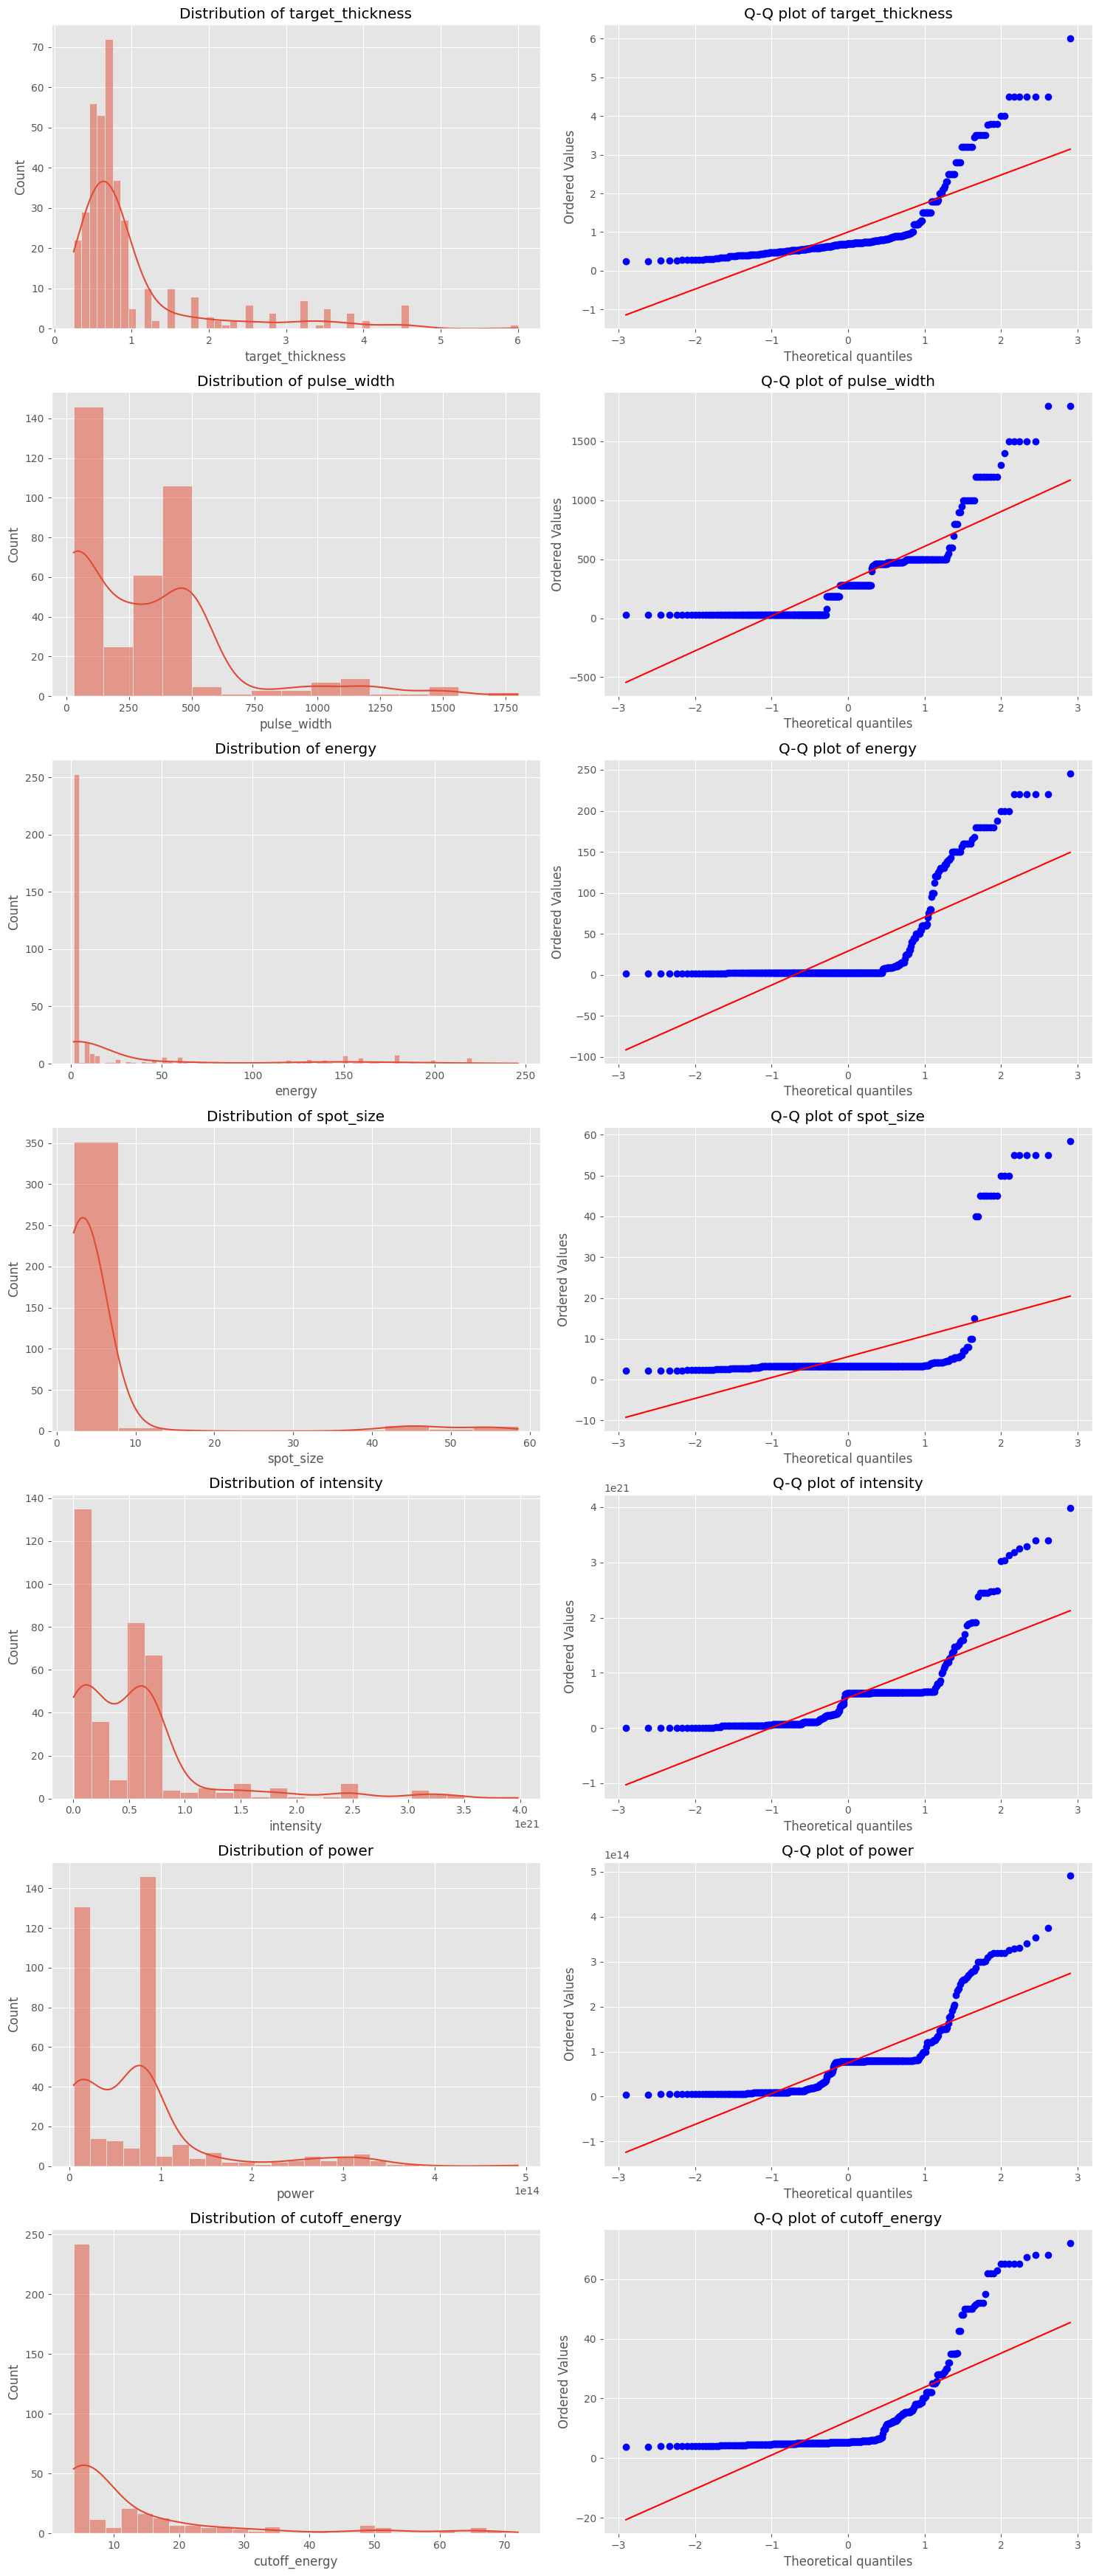

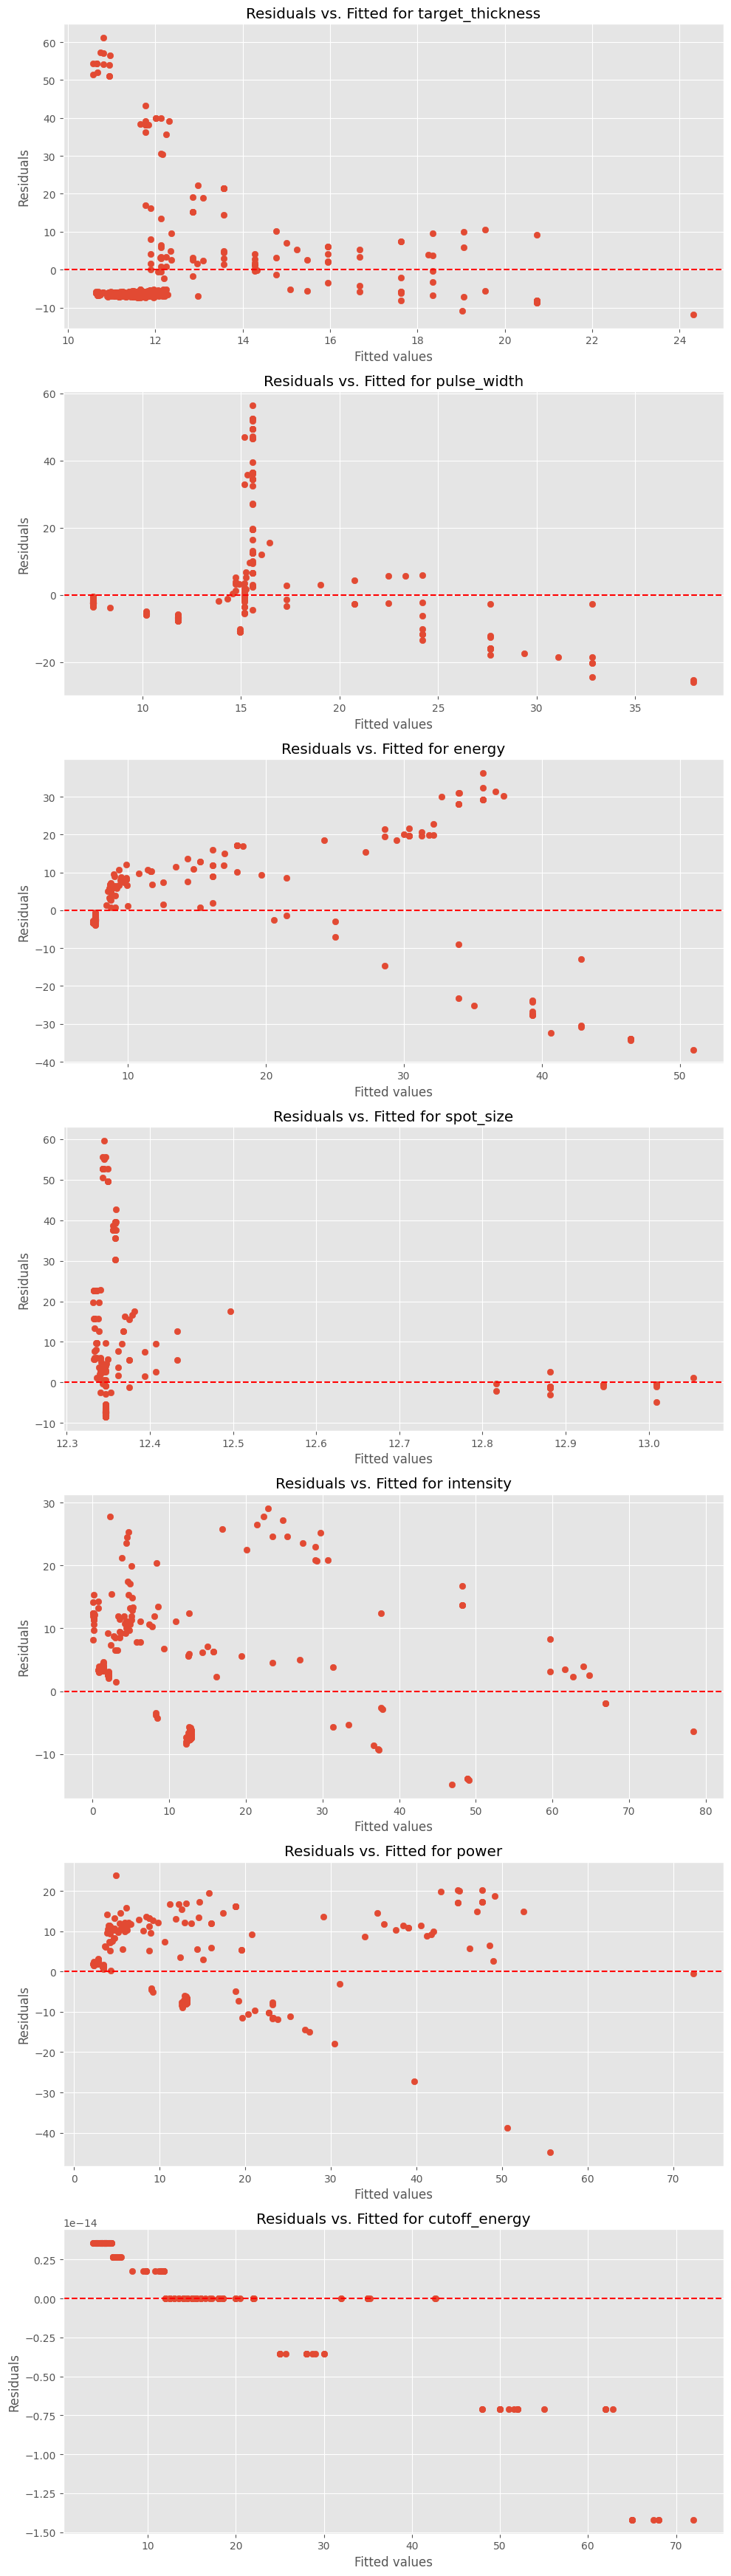

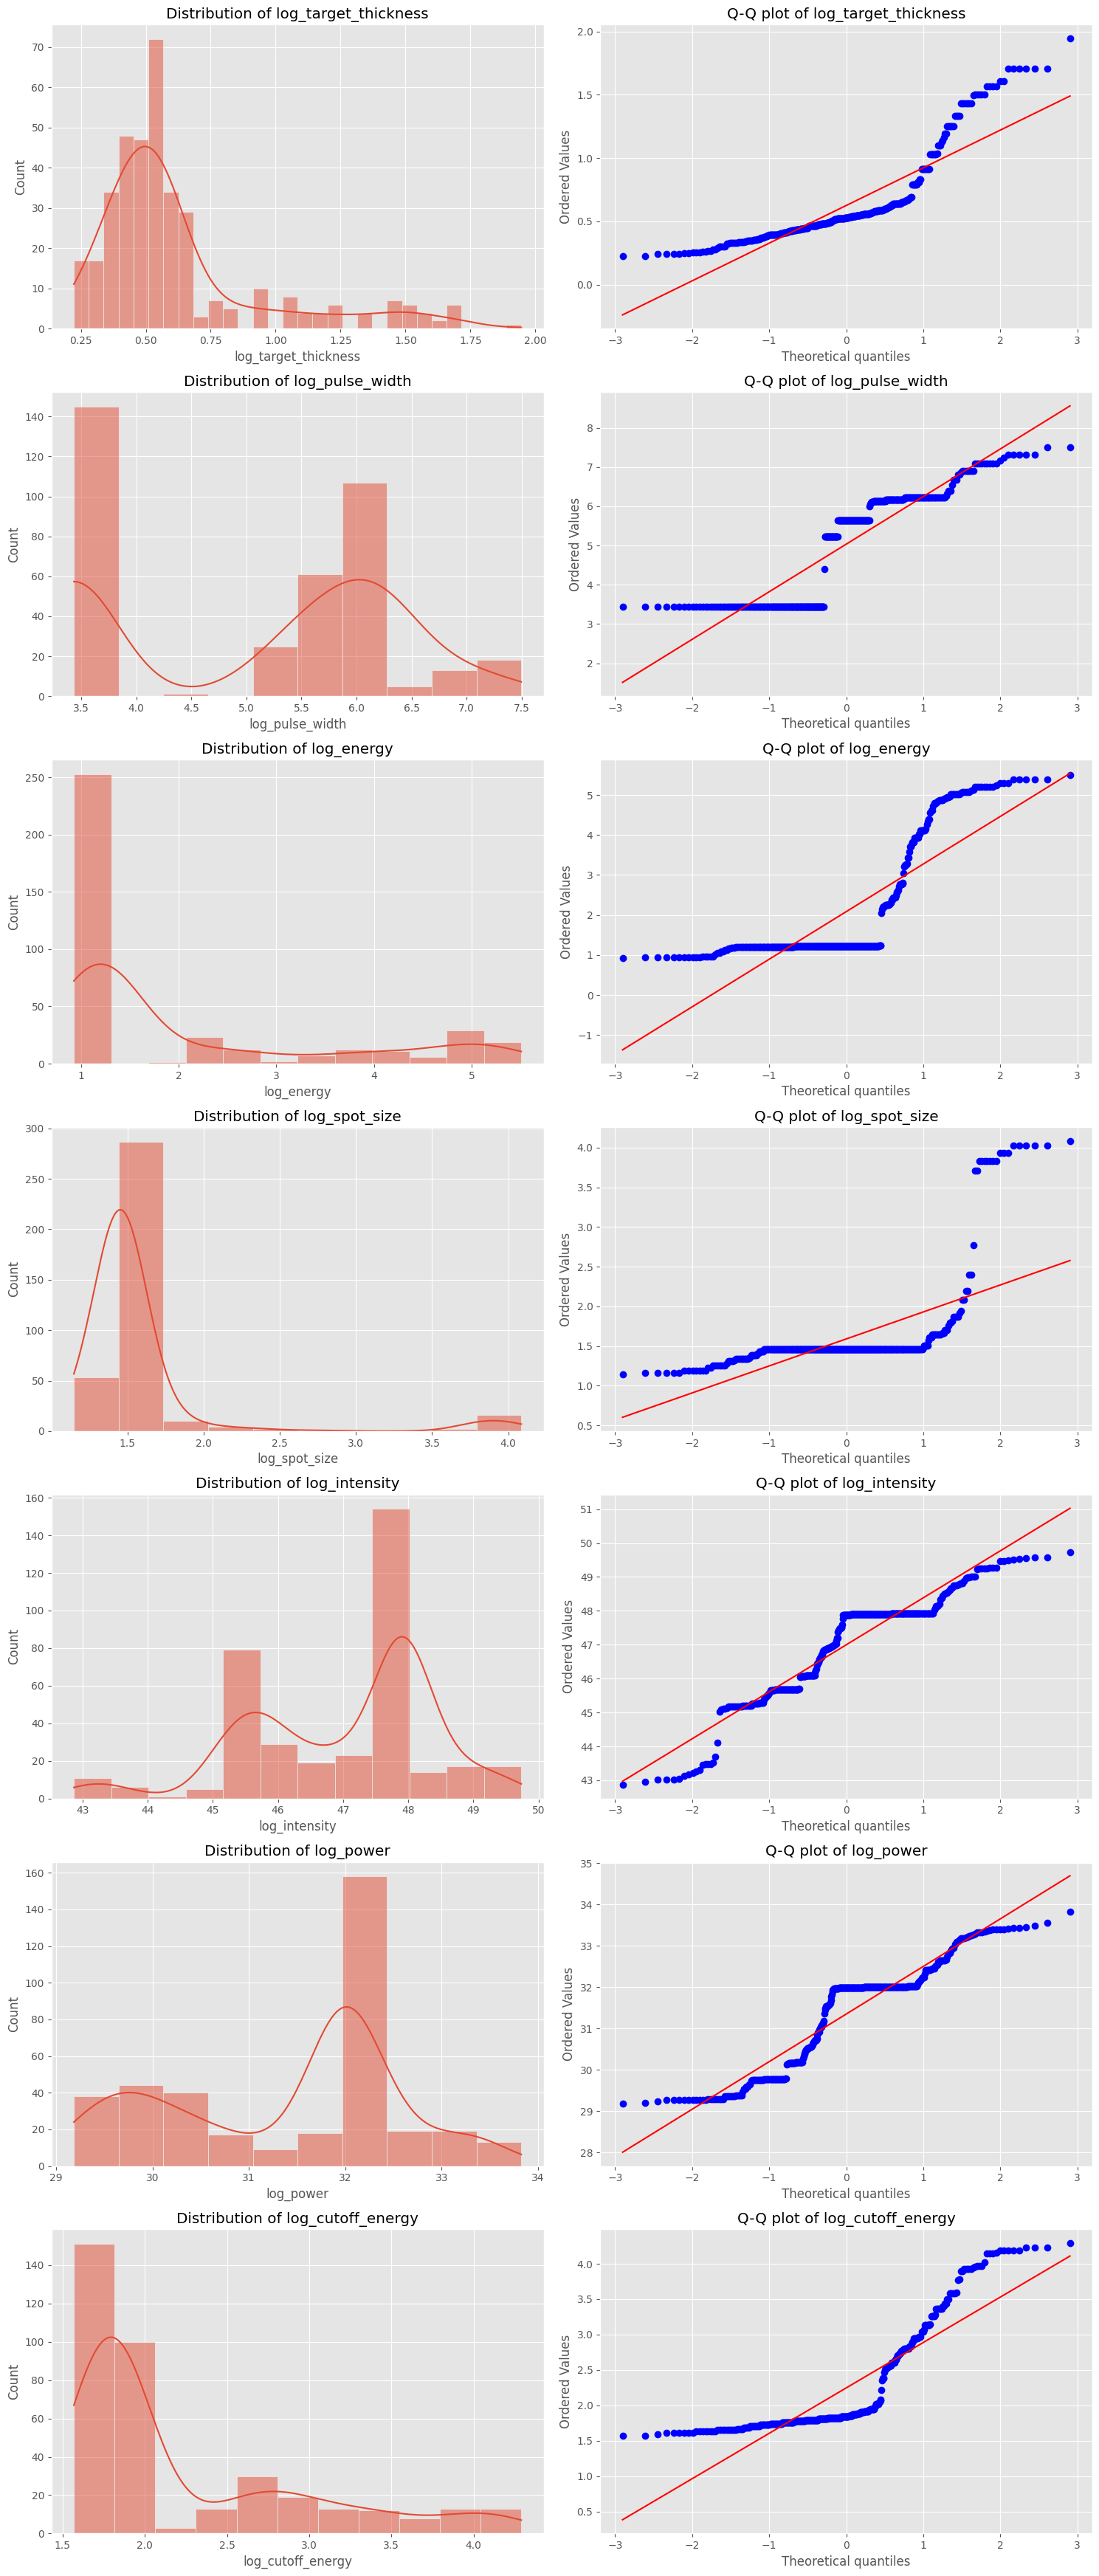


Normality Test Results for Log-Transformed Features:
log_target_thickness: p-value = 0.0000, Not Normal
log_pulse_width: p-value = 0.0000, Not Normal
log_energy: p-value = 0.0000, Not Normal
log_spot_size: p-value = 0.0000, Not Normal
log_intensity: p-value = 0.0000, Not Normal
log_power: p-value = 0.0000, Not Normal
log_cutoff_energy: p-value = 0.0000, Not Normal


In [20]:
### Other statistical tests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols

def test_normality_and_heteroscedasticity(data, feature_names):
    """
    Test for normality and heteroscedasticity in the given features.
    
    Parameters:
    data: pandas DataFrame containing the features
    feature_names: list of feature names to analyze
    
    Returns:
    normality_results: dict with normality test results
    heteroscedasticity_results: dict with heteroscedasticity test results
    """
    normality_results = {}
    heteroscedasticity_results = {}
    
    for feature in feature_names:
        # Shapiro-Wilk test for normality
        _, p_value = stats.shapiro(data[feature])
        normality_results[feature] = {
            'p_value': p_value,
            'is_normal': p_value > 0.05
        }
        
        # Breusch-Pagan test for heteroscedasticity
        # We'll use 'cutoff_energy' as the dependent variable for this example
        model = ols(f'cutoff_energy ~ {feature}', data=data).fit()
        _, p_value, _, _ = het_breuschpagan(model.resid, model.model.exog)
        heteroscedasticity_results[feature] = {
            'p_value': p_value,
            'is_homoscedastic': p_value > 0.05
        }
    
    return normality_results, heteroscedasticity_results

def plot_distributions_and_qq(data, feature_names):
    """
    Plot histograms and Q-Q plots for the given features.
    
    Parameters:
    data: pandas DataFrame containing the features
    feature_names: list of feature names to plot
    """
    n_features = len(feature_names)
    fig, axes = plt.subplots(n_features, 2, figsize=(15, 5*n_features))
    
    for i, feature in enumerate(feature_names):
        # Histogram
        sns.histplot(data[feature], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Distribution of {feature}')
        axes[i, 0].set_xlabel(feature)
        
        # Q-Q plot
        stats.probplot(data[feature], dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title(f'Q-Q plot of {feature}')
    
    plt.tight_layout()
    plt.show()

def plot_residuals(data, feature_names):
    """
    Plot residuals vs. fitted values for each feature against cutoff_energy.
    
    Parameters:
    data: pandas DataFrame containing the features
    feature_names: list of feature names to plot
    """
    n_features = len(feature_names)
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 5*n_features))
    
    for i, feature in enumerate(feature_names):
        model = ols(f'cutoff_energy ~ {feature}', data=data).fit()
        fitted_values = model.fittedvalues
        residuals = model.resid
        
        axes[i].scatter(fitted_values, residuals)
        axes[i].set_xlabel('Fitted values')
        axes[i].set_ylabel('Residuals')
        axes[i].set_title(f'Residuals vs. Fitted for {feature}')
        axes[i].axhline(y=0, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()

# List of numeric features
numeric_features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Load your data
d_rm_outliers_tests = df.copy()
d_rm_outliers_tests = d_rm_outliers_tests.loc[(d_rm_outliers_tests['model'] == 'claude-3-5-sonnet-20240620') & (d_rm_outliers_tests['prompt_short'] == 'cov') & (d_rm_outliers_tests['sample_size'] == 'rs_size_50')]

# Test for normality and heteroscedasticity
normality_results, heteroscedasticity_results = test_normality_and_heteroscedasticity(d_rm_outliers_tests, numeric_features)

print("Normality Test Results:")
for feature, result in normality_results.items():
    print(f"{feature}: p-value = {result['p_value']:.4f}, {'Normal' if result['is_normal'] else 'Not Normal'}")

print("\nHeteroscedasticity Test Results:")
for feature, result in heteroscedasticity_results.items():
    print(f"{feature}: p-value = {result['p_value']:.4f}, {'Homoscedastic' if result['is_homoscedastic'] else 'Heteroscedastic'}")

# Plot distributions and Q-Q plots
plot_distributions_and_qq(d_rm_outliers_tests, numeric_features)

# Plot residuals
plot_residuals(d_rm_outliers_tests, numeric_features)

# Demonstrate log transformation
log_transformed_data = d_rm_outliers_tests.copy()
for feature in numeric_features:
    log_transformed_data[f'log_{feature}'] = np.log1p(d_rm_outliers_tests[feature])

# Plot distributions and Q-Q plots for log-transformed features
plot_distributions_and_qq(log_transformed_data, [f'log_{feature}' for feature in numeric_features])

# Test normality for log-transformed features
log_normality_results, _ = test_normality_and_heteroscedasticity(log_transformed_data, [f'log_{feature}' for feature in numeric_features])

print("\nNormality Test Results for Log-Transformed Features:")
for feature, result in log_normality_results.items():
    print(f"{feature}: p-value = {result['p_value']:.4f}, {'Normal' if result['is_normal'] else 'Not Normal'}")

In [21]:
import numpy as np
from scipy.stats import energy_distance
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tqdm import tqdm

def multivariate_energy_test(X, Y, n_permutations=1000):
    """
    Perform multivariate energy test between two datasets X and Y.
    
    Parameters:
    X, Y: numpy arrays of shape (n_samples, n_features)
    n_permutations: number of permutations for the permutation test
    
    Returns:
    test_statistic, p_value, effect_size
    """
    # Combine the datasets
    combined = np.vstack((X, Y))
    n = len(X)
    m = len(Y)
    
    # Calculate the observed test statistic
    observed_statistic = energy_distance(X, Y)
    
    # Perform permutation test
    permutation_statistics = []
    for _ in tqdm(range(n_permutations)):
        np.random.shuffle(combined)
        permuted_X = combined[:n]
        permuted_Y = combined[n:]
        permutation_statistics.append(energy_distance(permuted_X, permuted_Y))
    
    # Calculate p-value
    p_value = np.mean(np.array(permutation_statistics) >= observed_statistic)
    
    # Calculate effect size (normalized energy distance)
    effect_size = observed_statistic / np.sqrt(2)
    
    return observed_statistic, p_value, effect_size

# Load and preprocess the data
def load_and_preprocess_data(df):

    # Convert target_material to numerical using one-hot encoding
    df = pd.get_dummies(df, columns=['target_material'])
    
    # Standardize numerical features
    scaler = StandardScaler()
    numerical_columns = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    
    return df.values

load_and_preprocess_data
# Load the original and synthetic datasets
original_data = df_original
synthetic_data = df

# Perform the multivariate energy test
test_statistic, p_value, effect_size = multivariate_energy_test(original_data, synthetic_data)

print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Effect Size: {effect_size}")

# Calculate power (assuming alpha = 0.05)
alpha = 0.05
power = 1 - (p_value > alpha)
print(f"Power: {power}")

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 13 and the array at index 1 has size 12